# Détectez de faux billets (ACP)

## Mission 1
#### Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

- analyse de l'éboulis des valeurs propres ;
- représentation des variables par le cercle des corrélations ;
- représentation des individus par les plans factoriels ;
- analyser de la qualité de représentation et la contribution des individus.

#### Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.

## Sommaire
- [importation des librairies](#Importation-des-librairies)
- [importation et lecture des données](#Importation_lecture_données)
- [mission 1 : ACP](#acp)
     - [Test des bâtons brisés de Legendre & Legendre](#test_legendre)
     - [éboulis des valeurs propres](#eboulis_val_propres)
     - [cercle de corrélation](#cercle_correlation)
     - [projection des individus](#proj_individus)
     - [qualité de représentation des individus](#qualite_repr_individus)
     - [contribution des individus aux axes](#ctr_ind_axes)
     - [analyse de la qualité de représentation et de la contribution des variables](#qualite_var)
- [mission 2 : algorithme de classification](#mission2)
     - [clustering par KMeans](#KMeans)
         - [elbow method](#elbow_method)
         - [les groupes sont-ils distincts ?](#groupes_distincts)
             - [test de Levène](#test_levene)
             - [test de Student](#test_student)
     - [ACP sur les groupes KMeans](#acpK)
         - [éboulis des valeurs propres](#eboulisK)
         - [cercle de corrélation](#cercleK)
         - [projection des individus](#proj_ind_K)
- [mission 3 : régression logistique](#mission3)
    - [régression logistique avec Sklearn](#reg_log_sklearn)
        - [matrice de confusion](#m_conf_sk)
        - [évaluation du modèle](#eval_sk)
        - [importances des différentes variables sur le modèle logistique](#inf_var)
        - [courbe ROC](#roc_sk)
    - [programme avec fichier "example"](#example)
    - [programme de détection de faux billets](#prog_sk)
- [juste pour voir ...](#juste_voir)
    - [régression logistique avec Statsmodels avec différentes variables](#statsmodels)
    - [régression logistique sans centrage et réduction des données](#scaled)
    - [RandomForest](#rf)
    - [reprise du dataset avec les données centrées réduites puis construction du modèle logistique avec dans un premier temps TOUTES les variables (overfitting ????)](#a_nouveau)

### Importation des librairies <a class="anchor" id="Importation-des-librairies"></a>

In [1]:
# Importation des librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# pour les statistiques
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from yellowbrick.model_selection import FeatureImportances

# librairies pour les tests
from scipy.stats import ks_2samp
import scipy.stats as st
from scipy.stats import levene

# librairies pour l'ACP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.collections import LineCollection


# librairies pour le clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

from sklearn import decomposition, preprocessing

In [2]:
ENCODAGE = 'UTF-8'

In [3]:
sns.set(style="darkgrid")

In [4]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,7))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="#FC4E07")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="#f6021c", alpha=0.8)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='#3751f5')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
#             plt.show(block=False)      



In [5]:
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None, centroid=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
             
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,7))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                    
            # affichage des centroides   
            if centroid is not None:
                X_projected_c = pca.transform(centroid)
                plt.scatter(X_projected_c[:, d1], X_projected_c[:, d2], alpha=alpha, c='red', marker = 'd', s = 200)
                
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
#             plt.show(block=False)


In [6]:
# graphique des éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.figure(figsize=(7,7))
    plt.bar(np.arange(len(scree))+1, scree, color="#ff3f33")
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="#0c8ef4",marker='o')
    plt.xlabel("rang de l'axe d'inertie", size=12)
    plt.ylabel("pourcentage d'inertie", size=12)
    plt.title("Eboulis des valeurs propres", size=14)
#     plt.show(block=False)

In [7]:
def quel_groupe(df_cluster, idg):
    gpe1 = df_cluster[df_cluster['cluster']==np.unique(kmBis.labels_)[0]]
    gpe2 = df_cluster[df_cluster['cluster']==np.unique(kmBis.labels_)[1]]
# Si le groupe1 a plus de billets faux que le groupe 2
    if len(gpe1[gpe1['is_genuine'] == False ].value_counts()) > len(gpe2[gpe2['is_genuine'] == False ].value_counts()):
        gpefaux = np.unique(kmBis.labels_)[0]
        
        print('le groupe des faux billets est le groupe {}'.format(gpefaux))
        
    else :
        gpefaux = np.unique(kmBis.labels_)[1]
        print('le groupe des faux billets est le groupe {}'.format(gpefaux))  
    return gpefaux
            

In [8]:
def calculate_accuracy(classifier, X_train, X_test, y_train, y_test):
    classifier.fit(X_train, y_train)
    y_pred_train = classifier.predict(X_train)
    y_pred_test = classifier.predict(X_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    print('Train accuracy:', '{:.3f}'.format(accuracy_train), 'Test accuracy:', '{:.3f}'.format(accuracy_test))
    return accuracy_train, accuracy_test, classifier

In [9]:
def predict_billet(data_example):
    # Récupération des variables significatives pour notre modèle
    data_example_rlog = data_example[['height_right','margin_low','length']]
#     # Données centrées et réduites
    sc = StandardScaler()
    X_scaled = sc.fit_transform(data_example_rlog)
#     # Prédictions
    predictions = model_reg.predict(X_scaled)
    y_pred_proba = model_reg.predict_proba(X_scaled)[::,1]
#     # Présentation des données dans un dataframe
    df_predictions = pd.DataFrame({'id': data_example.id.values,
                         'predictions' : predictions, 'probabilité' : y_pred_proba })
#     # Billet considéré comme vrai si proba >=0.5     
    df_predictions['is_genuine'] = ["True" if x >= 0.5 else "False" for x in df_predictions['probabilité']]
    return df_predictions 

### Importation et lecture des données <a class="anchor" id="Importation_lecture_données"></a>

In [10]:
df_notes = pd.read_csv('notes.csv', encoding= ENCODAGE).copy()

### ACP <a class="anchor" id="acp"></a>

#### Standardisation des données
- les variables ayant les mêmes unités, il ne serait pas nécessaire de réduire les données mais pour une meilleure compatibilité (pour examen ultérieur d'autres fichiers où les métriques seraient différentes), les données seront réduites.

In [11]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

In [12]:
df_notesIndex = df_notes.set_index('is_genuine')

In [13]:
# Sélection des colonnes à prendre en compte dans l'ACP
df_notes_pca = df_notes[['diagonal', 'height_left','height_right', 'margin_low', 'margin_up', 'length']]

In [14]:
# préparation des données pour l'ACP
df_notes_pca = df_notes_pca.fillna(df_notes_pca.mean()) 
X = df_notes_pca.values
names = df_notes['is_genuine'] 
features = df_notes.columns

In [15]:
# Centrage et réduction
scaler =  StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Vérification du centrage => moyenne = 0
np.mean(X_scaled, axis=0)

array([ 7.69580478e-15,  3.14728635e-14,  3.61958829e-14,  7.52339367e-16,
       -1.50467873e-15, -1.37510918e-14])

In [17]:
# Vérification de la réduction => écart-type=1
np.std(X_scaled, axis=0)

array([1., 1., 1., 1., 1., 1.])

In [18]:
# Nombre de composantes à calculer sur lesquelles faire les projections
n_comp = 6

#### Calcul des composantes principales

In [19]:
model_pca = PCA(n_components=n_comp)
X_reduced = model_pca.fit_transform(X_scaled)

In [20]:
X_reduced

array([[ 2.15363875,  1.59970945,  1.78745079,  2.43346523,  0.69968952,
        -1.26770217],
       [-2.11041589, -0.52603892,  0.54256277,  0.34454951,  0.0674404 ,
        -0.54460079],
       [-1.97315242, -0.04810178,  0.85871563,  0.37481231, -0.4248861 ,
         0.08048667],
       ...,
       [ 2.06724502,  0.84560244, -0.61028227, -1.71417169,  0.1169579 ,
        -0.50433787],
       [ 0.73925685, -0.97296457, -1.35977212, -0.19173617, -0.24355701,
         0.21142914],
       [ 1.50499242, -1.07972486,  0.18888855, -1.34755225, -0.2891493 ,
        -0.06034599]])

In [21]:
# Pourcentage de variance préservée pour chacune des composantes
np.cumsum(model_pca.explained_variance_ratio_)

array([0.47447921, 0.69405027, 0.83639551, 0.92165846, 0.96778669,
       1.        ])

In [22]:
np.argmax((np.cumsum(model_pca.explained_variance_ratio_))>0.90)

3

A partir de la 4ème composante, 92% de la variance est préservée.

In [23]:
df_notesIndex.shape

(170, 6)

In [24]:
# valeur corrigée
n = df_notesIndex.shape[0]
eigval = (n-1)/n*model_pca.explained_variance_
print(eigval)

[2.84687523 1.31742636 0.85407146 0.51157773 0.27676935 0.19327987]


Cumul de variance expliquée

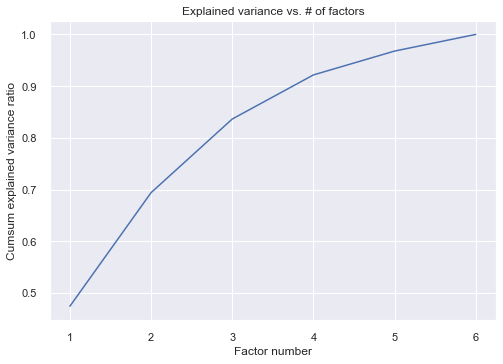

In [25]:
#cumul de variance expliquée
n_var = df_notesIndex.shape[1]
plt.plot(np.arange(1,n_var+1),np.cumsum(model_pca.explained_variance_ratio_))
plt.title("Explained variance vs. # of factors")
plt.ylabel("Cumsum explained variance ratio")
plt.xlabel("Factor number")
# plt.show()
plt.savefig("Explained variance vs. # of factors.jpg")

#### Test des bâtons brisés de Legendre & Legendre <a class="anchor" id="test_legendre"></a>

In [26]:
#seuils pour test des bâtons brisés
bs = 1/np.arange(n_var,0,-1)
bs = np.cumsum(bs)
bs = bs[::-1]

In [27]:
#test des bâtons brisés
print(pd.DataFrame({'Val.Propre':eigval,'Seuils':bs}))

   Val.Propre    Seuils
0    2.846875  2.450000
1    1.317426  1.450000
2    0.854071  0.950000
3    0.511578  0.616667
4    0.276769  0.366667
5    0.193280  0.166667


Il faut que la valeur propre associée à l'axe soit supérieure au seuil. Soit le premier axe (0 ici)

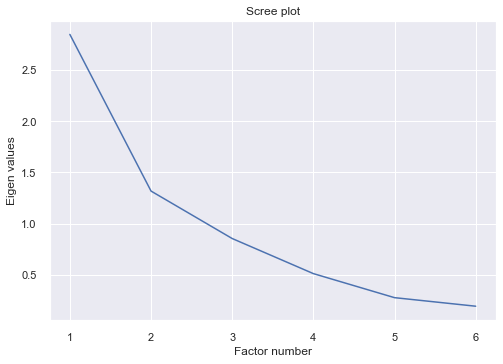

In [28]:
#scree plot
plt.plot(np.arange(1,n_var+1),eigval)
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
# plt.show()
plt.savefig("diag coude acp1.jpg")

### Réalisation d'un graphe des éboulis des valeurs propres <a class="anchor" id="eboulis_val_propres"></a>

<Figure size 720x720 with 0 Axes>

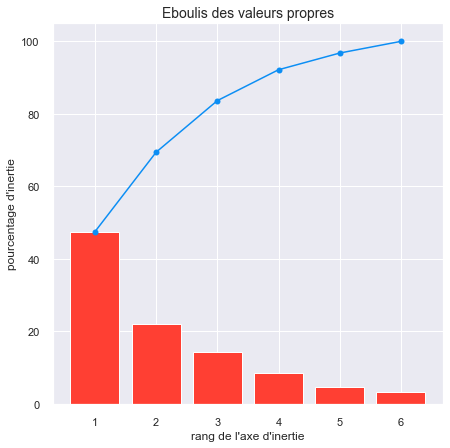

In [29]:
# Eboulis des valeurs propres
plt.figure(figsize=(10,10))
display_scree_plot(model_pca)
plt.savefig("Eboulis des valeurs propres échantillon initial.jpg")
plt.show()

Conclusion : 
- les trois premières composantes expliquent 83% de la variance
- les quatres premières composantes expliquent 92% de la variance - Nous travaillerons sur les 4 premières composantes afin de conserver un maximum de variance et donc d'infos

#### Contribution des individus dans l'inertie totale <a class="anchor" id="eboulis_val_propres"></a>

In [30]:
# Contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
df_contribution = pd.DataFrame({'ID':df_notesIndex.index,'d_i':di})
df_contribution

ID        d_i
0     True  18.410598
1     True   5.444799
2     True   4.960527
3     True   4.805719
4     True  18.039567
..     ...        ...
165  False   7.673233
166  False  20.625650
167  False   8.567410
168  False   3.482926
169  False   5.369633

[170 rows x 2 columns]

In [31]:
cos2 = X_reduced**2

In [32]:
# Qualité de représentation des individus - COS2 de l’angle qu’il forme avec sa projection sur les différents axes  
cos2 = X_reduced**2

for j in range(n_comp):
    cos2[:,j] = cos2[:,j]/di
qualite_representIndiv = pd.DataFrame({'id':df_notesIndex.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]})
print("Qualité de représentation des individus par axe :\n", qualite_representIndiv)

Qualité de représentation des individus par axe :
         id    COS2_1    COS2_2
0     True  0.251929  0.139000
1     True  0.818002  0.050822
2     True  0.784862  0.000466
3     True  0.882856  0.001652
4     True  0.320145  0.009417
..     ...       ...       ...
165  False  0.800651  0.004703
166  False  0.324059  0.411824
167  False  0.498809  0.083461
168  False  0.156908  0.271800
169  False  0.421817  0.217111

[170 rows x 3 columns]


In [33]:
# Vérification de la théorie - somme en ligne des cos2 = 1 => != 1 car pas on n'a pas pris tous les facteurs
print(np.sum(cos2,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


Visualisation de la qualité de représentation des billets (cos²)

In [34]:
qualite_representIndiv['id_billet'] = qualite_representIndiv.index

In [35]:
qualite_representIndiv['COS²'] = np.sum(cos2,axis=1)

In [36]:
px.bar(qualite_representIndiv, x = 'id_billet', y = 'COS²', color=qualite_representIndiv.index)

Ré entrainement du modèle avec le nombre de composantes choisi précédemment

In [37]:
n_comp = 4

In [38]:
# Calcul des composantes principales 
model_pca = PCA(n_components = n_comp)
#  X_reduced : coordonnées factorielles
X_reduced = model_pca.fit_transform(X_scaled)

In [39]:
model_pca

PCA(n_components=4)

In [40]:
# Vecteurs propres
model_pca.components_

array([[ 0.07327499,  0.47550205,  0.4918214 ,  0.43102671,  0.35253984,
        -0.46537288],
       [ 0.77963908,  0.33925019,  0.23554253, -0.32053699, -0.14111974,
         0.31453645],
       [-0.08889419,  0.12276016,  0.15383022,  0.5128076 , -0.82114881,
         0.12691346],
       [-0.55973158,  0.2780463 ,  0.45893794, -0.22652773,  0.13533955,
         0.57370304]])

### Cercle de corrélation <a class="anchor" id="cercle_correlation"></a>

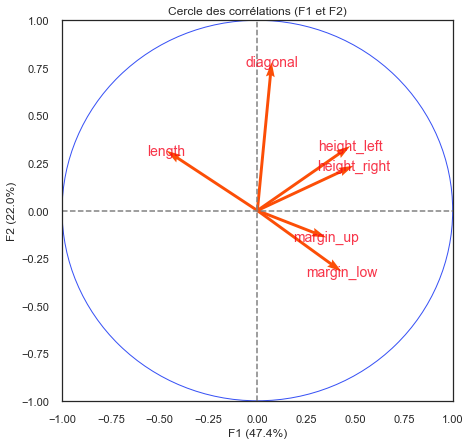

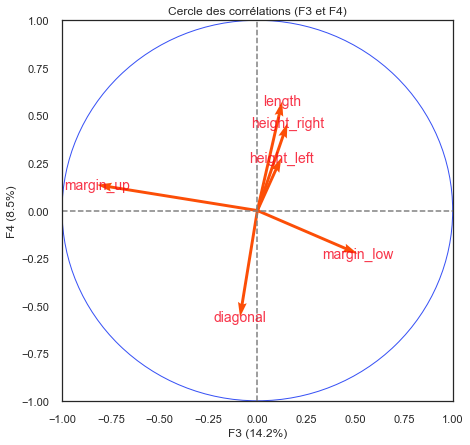

In [41]:
# Cercle des corrélations
sns.set_style("white")
var = df_notes_pca.columns
pcs = model_pca.components_
display_circles(pcs, n_comp, model_pca, [(0,1), (2,3)], labels = np.array(var))
plt.savefig("Cercle des corrélations echantillon initial.jpg", transparent=True)

In [42]:
df_notes_pca.head(1)

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83

In [43]:
for i in range(0,n_comp):
    print('f{} = {}'.format((i+1),model_pca.components_[i]))    

f1 = [ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
f2 = [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]
f3 = [-0.08889419  0.12276016  0.15383022  0.5128076  -0.82114881  0.12691346]
f4 = [-0.55973158  0.2780463   0.45893794 -0.22652773  0.13533955  0.57370304]


In [44]:
n_comp

4

Conclusion :
- sur F1 : height_left, height_right sont les plus corrélées à l'axe
- sur F2 : diagonal est la plus corrélée
- sur F3 : margin_low et margin_up sont les plus corrélées
- sur F4 : diagonal et length sont les plus corrélées

In [45]:
# Composantes principales F1 et F2 (combinaisons linéaires des variables initiales)
pd.DataFrame(X_reduced, index=df_notes.is_genuine, columns=["F"+str(i+1) for i in range(n_comp)])

F1        F2        F3        F4
is_genuine                                        
True        2.153639  1.599709  1.787451  2.433465
True       -2.110416 -0.526039  0.542563  0.344550
True       -1.973152 -0.048102  0.858716  0.374812
True       -2.059795 -0.089105 -0.531529  0.519548
True       -2.403180  0.412170  3.319507 -0.837043
...              ...       ...       ...       ...
False       2.478626  0.189974 -0.814598  0.107861
False       2.585331  2.914472  0.586789 -2.183704
False       2.067245  0.845602 -0.610282 -1.714172
False       0.739257 -0.972965 -1.359772 -0.191736
False       1.504992 -1.079725  0.188889 -1.347552

[170 rows x 4 columns]

#### Vérification des corrélations entre les variables

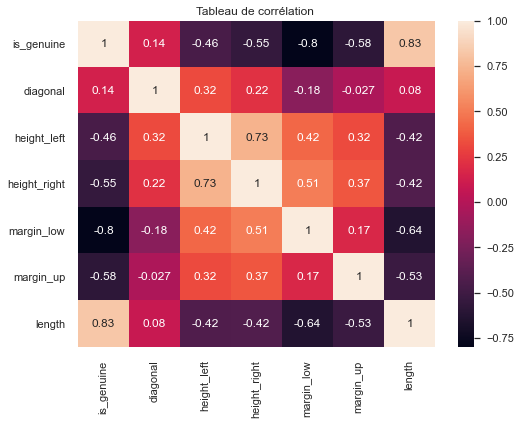

In [46]:
plt.figure(figsize=(8, 6))
# sns.heatmap(df_notes.drop('is_genuine', axis=1).corr(method='pearson'), annot=True)
sns.heatmap(df_notes.corr(method='pearson'), annot=True)
plt.title('Tableau de corrélation ')
# plt.show()
plt.savefig("Tableau de corrélation acp1 .jpg")


Remarque :
- Grande corrélation avec length et is_genuine (0.83)
- corrélation avec height_right et height_left (0.73)

### Projection des individus <a class="anchor" id="proj_individus"></a>

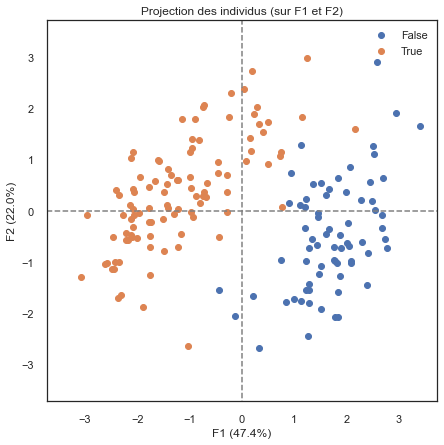

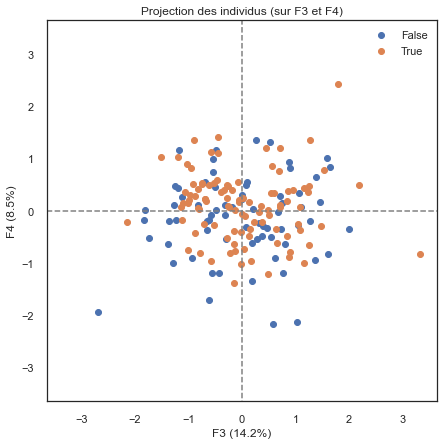

In [47]:
# Projection des billets
X_projected = model_pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, model_pca, [(0,1),(2,3)], illustrative_var=df_notes['is_genuine'])

# plt.show()
plt.savefig("Projection des billets echantillon initial.jpg")

La projection des individus sur  les 3ème et 4ème composantes est confuse.

#### Représentation et projection des centroïdes

In [48]:
df_centroïde = df_notes.groupby('is_genuine').mean().reset_index()
illustrative_var = df_centroïde.is_genuine
df_centroïde = df_centroïde.set_index('is_genuine')
df_centroïde

diagonal  height_left  height_right  margin_low  margin_up  \
is_genuine                                                                 
False       171.889857   104.230429    104.145571    5.281571   3.334571   
True        171.976100   103.951500    103.775900    4.143500   3.055500   

                length  
is_genuine              
False       111.660714  
True        113.207200

In [49]:
Xc = df_centroïde.values
std_scalec = StandardScaler().fit(X)
X_scaledc = std_scalec.transform(Xc)

In [50]:
X_scaledc

array([[-0.16640359,  0.55187289,  0.65894022,  0.95631526,  0.69658013,
        -0.98695112],
       [ 0.11648251, -0.38631103, -0.46125815, -0.66942068, -0.48760609,
         0.69086579]])

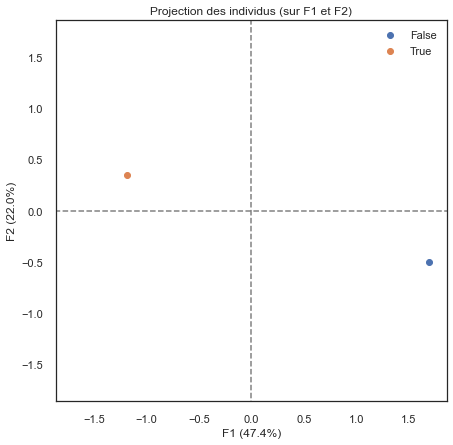

In [51]:
# Projection des des centroïdes
X_projected_c = model_pca.transform(X_scaledc)
display_factorial_planes(X_projected_c, n_comp, model_pca, [(0,1)], illustrative_var=df_centroïde.index)

# plt.show()
plt.savefig("Projection des centroides echantillon initial.jpg")

### Analyse de la qualité de représentation et la contribution des individus 

Pour mesurer la qualité de représentation des individus sur les axes, il faut calculer les cos²

In [52]:
#coordonnées factorielles des individus 
df_composante = pd.DataFrame(X_reduced, index=df_notesIndex.index, columns=["F"+str(i+1) for i in range(n_comp)])
df_composante.head(2)

F1        F2        F3        F4
is_genuine                                        
True        2.153639  1.599709  1.787451  2.433465
True       -2.110416 -0.526039  0.542563  0.344550

Calcul des carrés des distances des individus à l'origine (contribution à l'inertie totale)

In [53]:
df_notes

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0          True    171.81       104.86        104.95        4.52       2.89   
1          True    171.67       103.74        103.70        4.01       2.87   
2          True    171.83       103.76        103.76        4.40       2.88   
3          True    171.80       103.78        103.65        3.73       3.12   
4          True    172.05       103.70        103.75        5.04       2.27   
..          ...       ...          ...           ...         ...        ...   
165       False    172.11       104.23        104.45        5.24       3.58   
166       False    173.01       104.59        104.31        5.04       3.05   
167       False    172.47       104.27        104.10        4.88       3.33   
168       False    171.82       103.97        103.88        4.73       3.55   
169       False    171.96       104.00        103.95        5.63       3.26   

     length  
0    112.83  
1    113.29  
2    113.84  
3    113.63  
4    113.55  
..      ...  
165  111.78  
166  110.91  
167  110.68  
168  111.87  
169  110.96  

[170 rows x 7 columns]

In [54]:
# Contribution des individus dans l'inertie totale
di = np.sum(X_scaled**2,axis=1)
df_contribution = pd.DataFrame({'ID':df_notesIndex.index,'d_i':di})

In [55]:
df_contribution.sort_values(by= 'd_i', ascending=False).head(2)

ID        d_i
166  False  20.625650
0     True  18.410598

#### Qualité de la représentation des individus <a class="anchor" id="qualite_repr_individus"></a>

In [56]:
X_reduced.shape

(170, 4)

In [57]:
# Qualité de représentation des individus - COS2 de l’angle qu’il forme avec sa projection sur les différents axes  
cos2 = X_reduced**2

for j in range(n_comp):
    cos2[:,j] = cos2[:,j]/di
qualite_representIndiv = pd.DataFrame({'id':df_notes.index,'COS2_F1':cos2[:,0],'COS2_F2':cos2[:,1]})
print("Qualité de représentation des individus par axe :\n", qualite_representIndiv)

Qualité de représentation des individus par axe :
       id   COS2_F1   COS2_F2
0      0  0.251929  0.139000
1      1  0.818002  0.050822
2      2  0.784862  0.000466
3      3  0.882856  0.001652
4      4  0.320145  0.009417
..   ...       ...       ...
165  165  0.800651  0.004703
166  166  0.324059  0.411824
167  167  0.498809  0.083461
168  168  0.156908  0.271800
169  169  0.421817  0.217111

[170 rows x 3 columns]


In [58]:
cos2.shape

(170, 4)

In [59]:
# plus gdes valeurs de cos2_1
qual_rep_indiv_F1 = qualite_representIndiv.drop('id', axis=1).sort_values('COS2_F1', ascending=False).head(10)

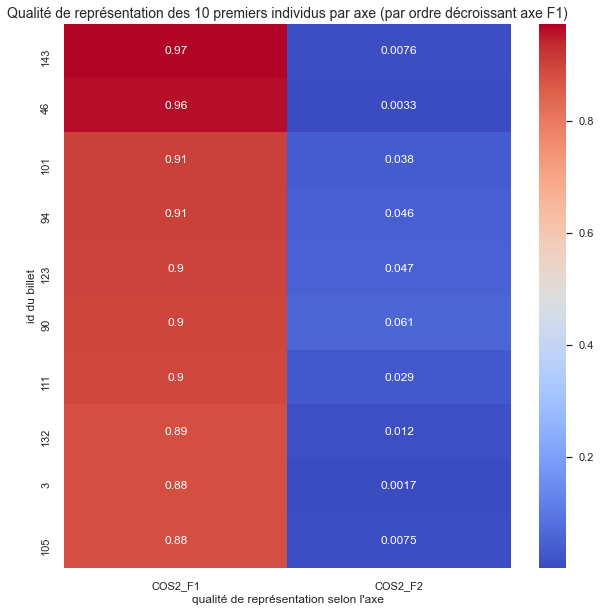

In [60]:
plt.figure(figsize=(10,10))
sns.heatmap(qual_rep_indiv_F1, cmap='coolwarm', annot=True, annot_kws={'size':12})
plt.ylabel('id du billet', size= 12)
plt.xlabel('qualité de représentation selon l\'axe', size= 12)
plt.title('Qualité de représentation des 10 premiers individus par axe (par ordre décroissant axe F1)', size=14)
# plt.show()
plt.savefig("Qualité de représentation des individus par axe par ordre décroissant.jpg")

In [61]:
# plus gdes valeurs de cos2_2
qual_rep_indiv_F2 = qualite_representIndiv.drop('id', axis=1).sort_values('COS2_F2', ascending=False).head(10)

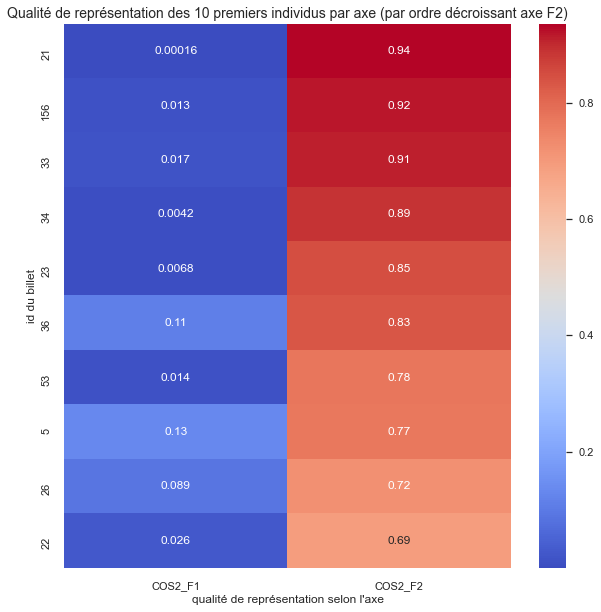

In [62]:
plt.figure(figsize=(10,10))
sns.heatmap(qual_rep_indiv_F2, cmap='coolwarm', annot=True, annot_kws={'size':12})
plt.ylabel('id du billet', size= 12)
plt.xlabel('qualité de représentation selon l\'axe', size= 12)
plt.title('Qualité de représentation des 10 premiers individus par axe (par ordre décroissant axe F2)', size=14)
# plt.show()
plt.savefig("Qualité de représentation des individus par axe (par ordre décroissant axe F2).jpg")

La qualité de représentation d'individu est max sur un seul axe (forte valeur pour un axe et faible valeur pour l'autre)

In [63]:
# Vérification de la théorie - somme en ligne des cos2 = 1 => != 1 car pas on n'a pas tout pris 
print(np.sum(cos2,axis=1))

[0.88611808 0.9446925  0.96230112 0.9994651  0.97923231 0.99633819
 0.82140532 0.98866683 0.73567479 0.91456677 0.95916812 0.88498141
 0.45857512 0.97576623 0.99153695 0.92132846 0.82561035 0.99678605
 0.91620527 0.96033078 0.91533823 0.93824831 0.79728008 0.9914021
 0.86580822 0.94308688 0.9349085  0.97509871 0.94343772 0.9817057
 0.96551521 0.97806709 0.81759618 0.98325948 0.96723346 0.99857198
 0.99757606 0.9615814  0.98252988 0.54604985 0.92662755 0.62202336
 0.99444721 0.35356587 0.99960908 0.99411582 0.99163779 0.99955579
 0.8435375  0.86804298 0.91288993 0.86675838 0.83807667 0.97581313
 0.94591264 0.96789723 0.88345882 0.96797364 0.99053633 0.99356573
 0.99174688 0.99733244 0.9464016  0.91766407 0.95612714 0.86273185
 0.99511685 0.99187463 0.87985607 0.65851629 0.9743787  0.98351713
 0.27069372 0.95950135 0.98762856 0.97898578 0.70620046 0.91489099
 0.7282447  0.96111619 0.83974731 0.88319095 0.94337335 0.98714774
 0.92066121 0.90085054 0.99521224 0.87165439 0.87301734 0.968383

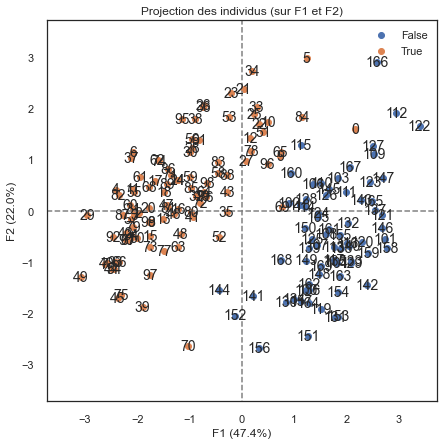

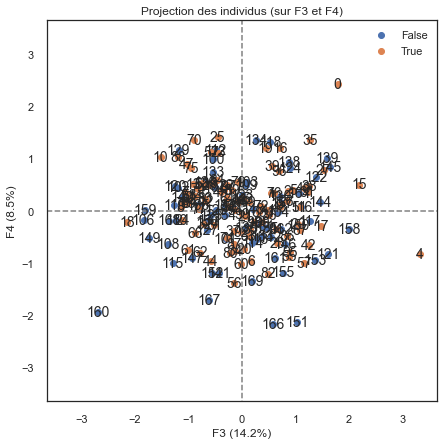

In [64]:
# Projection des billets pour visualiser les billets les mieux représentés
id_billet = df_notes.index
display_factorial_planes(X_projected, n_comp, model_pca, [(0,1),(2,3)], illustrative_var=df_notes['is_genuine'], labels = np.array(id_billet))
# plt.show()
plt.savefig("Projection des billets echantillon initial avec ID.jpg")

In [65]:
X_projected[46]

array([-1.30788205, -0.07708604, -0.05346001,  0.20822224])

In [66]:
X_projected[21]

array([ 0.03144616,  2.37337698,  0.05952122, -0.10561741])

#### Contributions des individus aux axes <a class="anchor" id="ctr_ind_axes"></a>

In [67]:
#contributions aux axes
ctr = X_reduced**2
for j in range(n_comp):
    ctr[:,j] = ctr[:,j]/(n*eigval[j]) 
contributionAxes = pd.DataFrame({'id':df_notes.index,'CTR_F1':ctr[:,0],'CTR_F2':ctr[:,1]})
print("Contributions aux axes :\n", contributionAxes)

Contributions aux axes :
       id    CTR_F1    CTR_F2
0      0  0.009584  0.011426
1      1  0.009203  0.001236
2      2  0.008045  0.000010
3      3  0.008767  0.000035
4      4  0.011933  0.000759
..   ...       ...       ...
165  165  0.012694  0.000161
166  166  0.013811  0.037927
167  167  0.008830  0.003193
168  168  0.001129  0.004227
169  169  0.004680  0.005205

[170 rows x 3 columns]


In [68]:
# Vérification de la théorie
print(np.sum(ctr,axis=0))

[1. 1. 1. 1.]


In [69]:
contributionAxes

id    CTR_F1    CTR_F2
0      0  0.009584  0.011426
1      1  0.009203  0.001236
2      2  0.008045  0.000010
3      3  0.008767  0.000035
4      4  0.011933  0.000759
..   ...       ...       ...
165  165  0.012694  0.000161
166  166  0.013811  0.037927
167  167  0.008830  0.003193
168  168  0.001129  0.004227
169  169  0.004680  0.005205

[170 rows x 3 columns]

In [70]:
# plus gdes valeurs de CTR_1
contributionAxes_ind_F1 = contributionAxes.drop('id', axis=1).sort_values('CTR_F1', ascending=False).head(10)

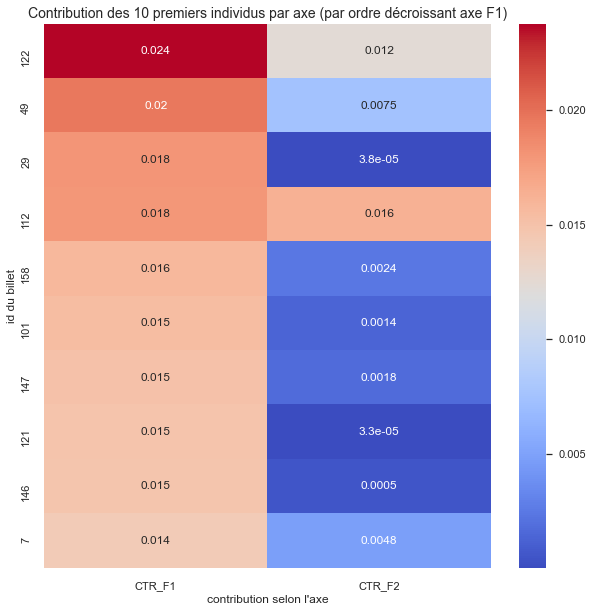

In [71]:
plt.figure(figsize=(10,10))
sns.heatmap(contributionAxes_ind_F1, cmap='coolwarm', annot=True, annot_kws={'size':12})
plt.ylabel('id du billet', size= 12)
plt.xlabel('contribution selon l\'axe', size= 12)
plt.title('Contribution des 10 premiers individus par axe (par ordre décroissant axe F1)', size=14)
# plt.show()
plt.savefig("contributionAxes_ind_F1 .jpg")

In [72]:
# plus gdes valeurs de CTR_2
contributionAxes_ind_F2 = contributionAxes.drop('id', axis=1).sort_values('CTR_F2', ascending=False).head(10)

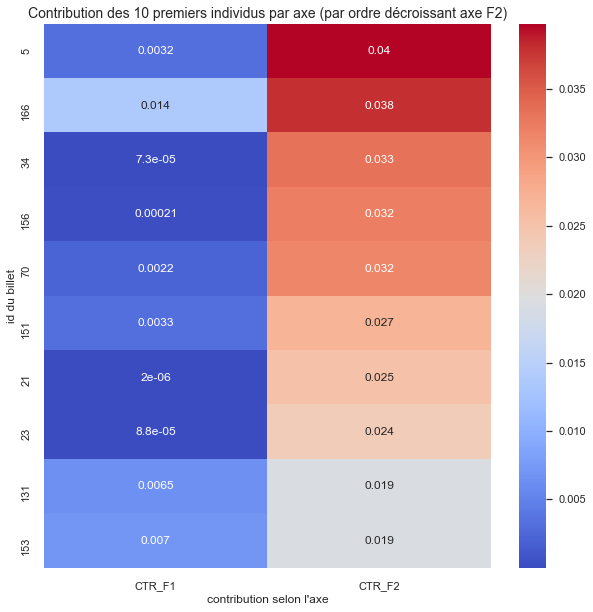

In [73]:
plt.figure(figsize=(10,10))
sns.heatmap(contributionAxes_ind_F2, cmap='coolwarm', annot=True, annot_kws={'size':12})
plt.ylabel('id du billet', size= 12)
plt.xlabel('contribution selon l\'axe', size= 12)
plt.title('Contribution des 10 premiers individus par axe (par ordre décroissant axe F2)', size=14)
# plt.show()
plt.savefig("contributionAxes_ind_F2 .jpg")

Les individus contribuent plus à un axe qu'à l'autre

### Analyse de la qualité de représentation et de la contribution des variables 

#### Qualité de représentation des variables (COS²) <a class="anchor" id="qualite_var"></a>

In [74]:
#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

In [75]:
model_pca.components_

array([[ 0.07327499,  0.47550205,  0.4918214 ,  0.43102671,  0.35253984,
        -0.46537288],
       [ 0.77963908,  0.33925019,  0.23554253, -0.32053699, -0.14111974,
         0.31453645],
       [-0.08889419,  0.12276016,  0.15383022,  0.5128076 , -0.82114881,
         0.12691346],
       [-0.55973158,  0.2780463 ,  0.45893794, -0.22652773,  0.13533955,
         0.57370304]])

In [76]:
# Corrélation des variables avec les axes
corvar = np.zeros((n_var,n_var))
for k in range(n_comp):
    corvar[:,k] = model_pca.components_[k,:] * sqrt_eigval[k]
# Affichage de la matrice des corrélations variables x facteurs 
print(corvar)

[[ 0.1236346   0.89486346 -0.08215244 -0.40034612  0.          0.        ]
 [ 0.80229967  0.38938864  0.11345001  0.19887167  0.          0.        ]
 [ 0.8298348   0.27035382  0.14216371  0.32825381  0.          0.        ]
 [ 0.72725782 -0.36790977  0.4739162  -0.16202319  0.          0.        ]
 [ 0.59482939 -0.1619761  -0.75887278  0.09680115  0.          0.        ]
 [-0.78520903  0.36102241  0.11728832  0.41033916  0.          0.        ]]


In [77]:
#on affiche pour les deux premiers axes
print(pd.DataFrame({'variable':df_notesIndex.columns,'COR_F1':corvar[:,0],'COR_F2':corvar[:,1]}))

       variable    COR_F1    COR_F2
0      diagonal  0.123635  0.894863
1   height_left  0.802300  0.389389
2  height_right  0.829835  0.270354
3    margin_low  0.727258 -0.367910
4     margin_up  0.594829 -0.161976
5        length -0.785209  0.361022


In [78]:
#cosinus carré des variables
cos2var = corvar**2
qualite_representVar = pd.DataFrame({'variable':df_notesIndex.columns,'COS2_F1':cos2var[:,0],'COS2_F2':cos2var[:,1]})
qualite_representVarIndex = qualite_representVar.set_index('variable')

In [79]:
# plus gdes valeurs de cos2_1
qualite_representVarIndex = qualite_representVarIndex.sort_values('COS2_F1', ascending=False).head(10)

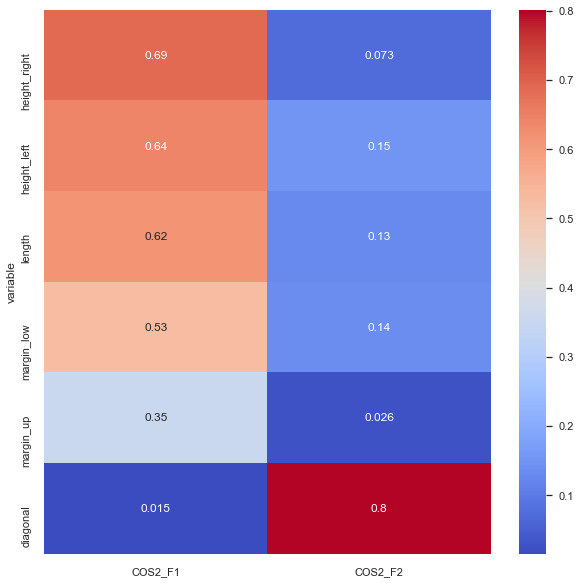

In [80]:
plt.figure(figsize=(10,10))
sns.heatmap(qualite_representVarIndex, cmap='coolwarm', annot=True, annot_kws={'size':12})
# plt.show()
plt.savefig("contribution cos2F1 var.jpg")

In [81]:
#vérification de la théorie => !=1 car on n'a pas tous les axes d'inerties
print(np.sum(cos2var,axis=1))

[0.98309217 0.84772912 0.88967806 0.91510962 0.96531662 0.92902518]


#### Contribution des variables aux axes (CTR)

In [82]:
# Contributions
ctrvar = cos2var

for k in range(n_var):
    ctrvar[:,k] = ctrvar[:,k]/eigval[k]

#on n'affiche que pour les deux premiers axes
contributionAxes_var = pd.DataFrame({'variable':df_notesIndex.columns,'CTR_F1':ctrvar[:,0],'CTR_F2':ctrvar[:,1]})
contributionAxes_varIndex = contributionAxes_var.set_index('variable')
contributionAxes_varIndex

CTR_F1    CTR_F2
variable                        
diagonal      0.005369  0.607837
height_left   0.226102  0.115091
height_right  0.241888  0.055480
margin_low    0.185784  0.102744
margin_up     0.124284  0.019915
length        0.216572  0.098933

In [83]:
# Vérification de la théorie
print(np.sum(ctrvar, axis=0))

[1. 1. 1. 1. 0. 0.]


In [84]:
# plus gdes valeurs de CTR_1
contributionAxes_var = contributionAxes_varIndex.sort_values('CTR_F1', ascending=False).head(10)

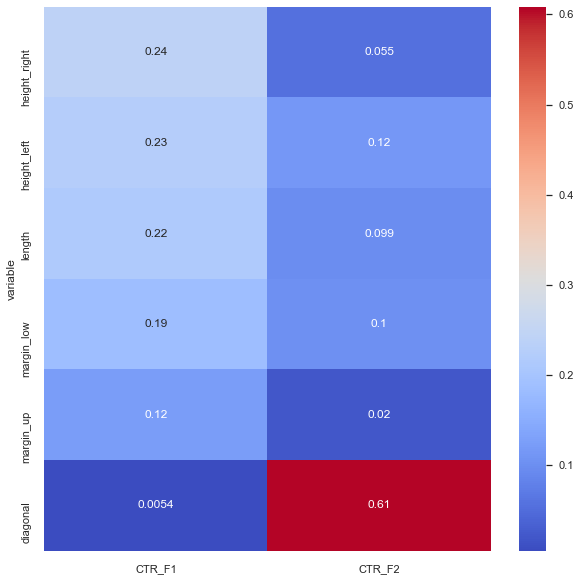

In [85]:
plt.figure(figsize=(10,10))
sns.heatmap(contributionAxes_var, cmap='coolwarm', annot=True, annot_kws={'size':12})
# plt.show()
plt.savefig("contributionAxes_var .jpg")

## Mission 2 <a class="anchor" id="mission2"></a>
#### Appliquez un algorithme de classification, puis analysez le résultat obtenu
#### Visualisez la partition obtenue dans le premier plan factoriel de l'ACP, puis analysez-la

### Clustering par KMeans <a class="anchor" id="KMeans"></a>

In [86]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

In [87]:
df_notes_pca.head(2)

diagonal  height_left  height_right  margin_low  margin_up  length
0    171.81       104.86        104.95        4.52       2.89  112.83
1    171.67       103.74        103.70        4.01       2.87  113.29

In [88]:
# Nombre de clusters
nb_cluster = 2

In [89]:
# préparation des données pour le clustering
Xgpe = df_notes_pca.values
# names = df_notes.index

In [90]:
#  Standardisation des données
scaler = StandardScaler()
X_scaledGpe = scaler.fit_transform(Xgpe)

In [91]:
# Vérification du centrage
X_scaledGpe.mean(axis=0)

array([ 7.69580478e-15,  3.14728635e-14,  3.61958829e-14,  7.52339367e-16,
       -1.50467873e-15, -1.37510918e-14])

In [92]:
#  Vérification de la réduction
X_scaledGpe.std(axis=0)

array([1., 1., 1., 1., 1., 1.])

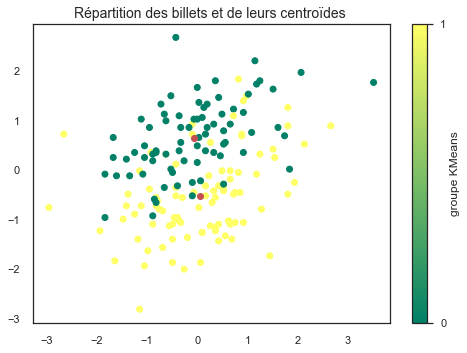

In [93]:
# Représentation des individus et des clusters (en vert) sur les 2 premières variables
km = KMeans(n_clusters=nb_cluster)
km.fit(X_scaledGpe)
km.predict(X_scaledGpe)
plt.scatter(X_scaledGpe[:,0], X_scaledGpe[:,1], c = km.predict(X_scaledGpe), cmap = plt.cm.summer)
plt.colorbar(ticks=range(2), label='groupe KMeans')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], c='r', cmap = plt.cm.summer)
plt.title('Répartition des billets et de leurs centroïdes ', size=14)
# plt.show()
plt.savefig("Répartition des billets et de leurs centroïdes.jpg")

In [94]:
km.labels_

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [95]:
km.cluster_centers_

array([[-0.06412378,  0.64653217,  0.72076527,  0.81585838,  0.64246416,
        -0.87782484],
       [ 0.05309173, -0.53530083, -0.59676264, -0.67549565, -0.53193269,
         0.72680122]])

In [96]:
np.unique(km.labels_, return_counts=True)

(array([0, 1]), array([77, 93], dtype=int64))

Elbow method  <a class="anchor" id="elbow_method"></a>

In [97]:
#  vérification du bon choix du nombre de clusters => elbow method
inertia=[]
k_range = range(1, 10)
for k in k_range :
    km = KMeans(n_clusters=k).fit(X_scaledGpe)
    inertia.append(km.inertia_)

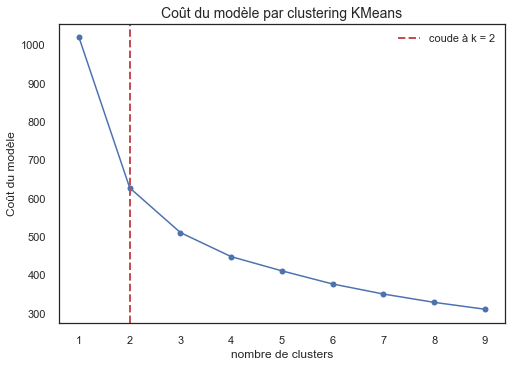

In [98]:
# Visualisation du elbow method
plt.plot(k_range, inertia, marker='o')
plt.title('Coût du modèle par clustering KMeans', size=14)
plt.xlabel('nombre de clusters')
plt.ylabel('Coût du modèle')
plt.axvline(x=2, color='r', linewidth=2, linestyle='dashed', label='coude à k = 2')
# plt.show()
plt.legend()
plt.savefig("diag coude Kmeans2.jpg")

In [99]:
# préparation des données pour le clustering
Xg = df_notes_pca.values

In [100]:
#  Standardisation des données
scaler = StandardScaler()
X_scaledG = scaler.fit_transform(Xg)

In [101]:
n_clusterBis = 2

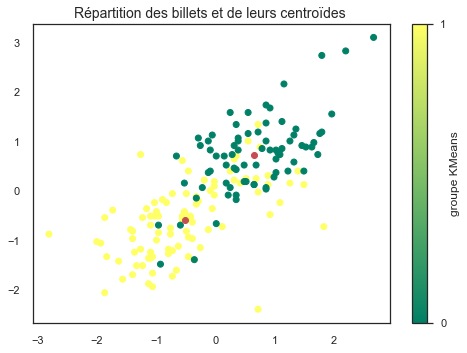

In [102]:
# Représentation des individus et des clusters (en vert) sur les 2 premières variables
kmBis = KMeans(n_clusters=n_clusterBis)
kmBis.fit(X_scaledG)
kmBis.predict(X_scaledG)
plt.scatter(X_scaledG[:,1], X_scaledG[:,2], c = kmBis.predict(X_scaledG), cmap = plt.cm.summer)
plt.colorbar(ticks=range(3), label='groupe KMeans')
plt.scatter(kmBis.cluster_centers_[:,1], kmBis.cluster_centers_[:,2], c='r', cmap = plt.cm.summer)
plt.title('Répartition des billets et de leurs centroïdes ', size=14)
# plt.show()
plt.savefig("Répartition des billets et de leurs centroïdes ACP2.jpg")

In [103]:
# Calcul du score de silhouette
score = silhouette_score(X_scaledG, kmBis.labels_, metric='euclidean')
print('Score Silhouette: %.3f' % score)

Score Silhouette: 0.352


On reste sur 2 groupes

In [104]:
# Coordonnées des centroïdes
centroidK = kmBis.cluster_centers_
centroidK

array([[-0.07918471,  0.64514123,  0.71861116,  0.84016633,  0.63084075,
        -0.90264532],
       [ 0.06402168, -0.52160355, -0.58100477, -0.67928342, -0.51004145,
         0.72979834]])

In [105]:
df_notesK = df_notes.copy()
df_notesK['cluster'] = kmBis.labels_

In [106]:
df_notesK.head(10)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.67       103.74        103.70        4.01       2.87   
2        True    171.83       103.76        103.76        4.40       2.88   
3        True    171.80       103.78        103.65        3.73       3.12   
4        True    172.05       103.70        103.75        5.04       2.27   
5        True    172.57       104.65        104.44        4.54       2.99   
6        True    172.38       103.55        103.80        3.97       2.90   
7        True    171.58       103.65        103.37        3.54       3.19   
8        True    171.96       103.51        103.75        4.06       3.33   
9        True    172.14       104.34        104.20        4.63       3.02   

   length  cluster  
0  112.83        0  
1  113.29        1  
2  113.84        1  
3  113.63        1  
4  113.55        1  
5  113.16        0  
6  113.30        1  
7  113.38        1  
8  113.53        1  
9  112.47        0

In [107]:
df_notesK.is_genuine.value_counts()

True     100
False     70
Name: is_genuine, dtype: int64

In [108]:
#  Effectif par groupe
np.unique(kmBis.labels_, return_counts=True)

(array([0, 1]), array([76, 94], dtype=int64))

In [109]:
# Regroupement par "groupe"
gb = df_notesK.groupby(kmBis.labels_)

In [110]:
gb.mean()

is_genuine    diagonal  height_left  height_right  margin_low  margin_up  \
0    0.092105  171.916447   104.258158    104.165263    5.200263   3.319079   
1    0.989362  171.960106   103.911277    103.736383    4.136596   3.050213   

       length  cluster  
0  111.738421        0  
1  113.243085        1

In [111]:
# Effectif par groupe
gb.size()

0    76
1    94
dtype: int64

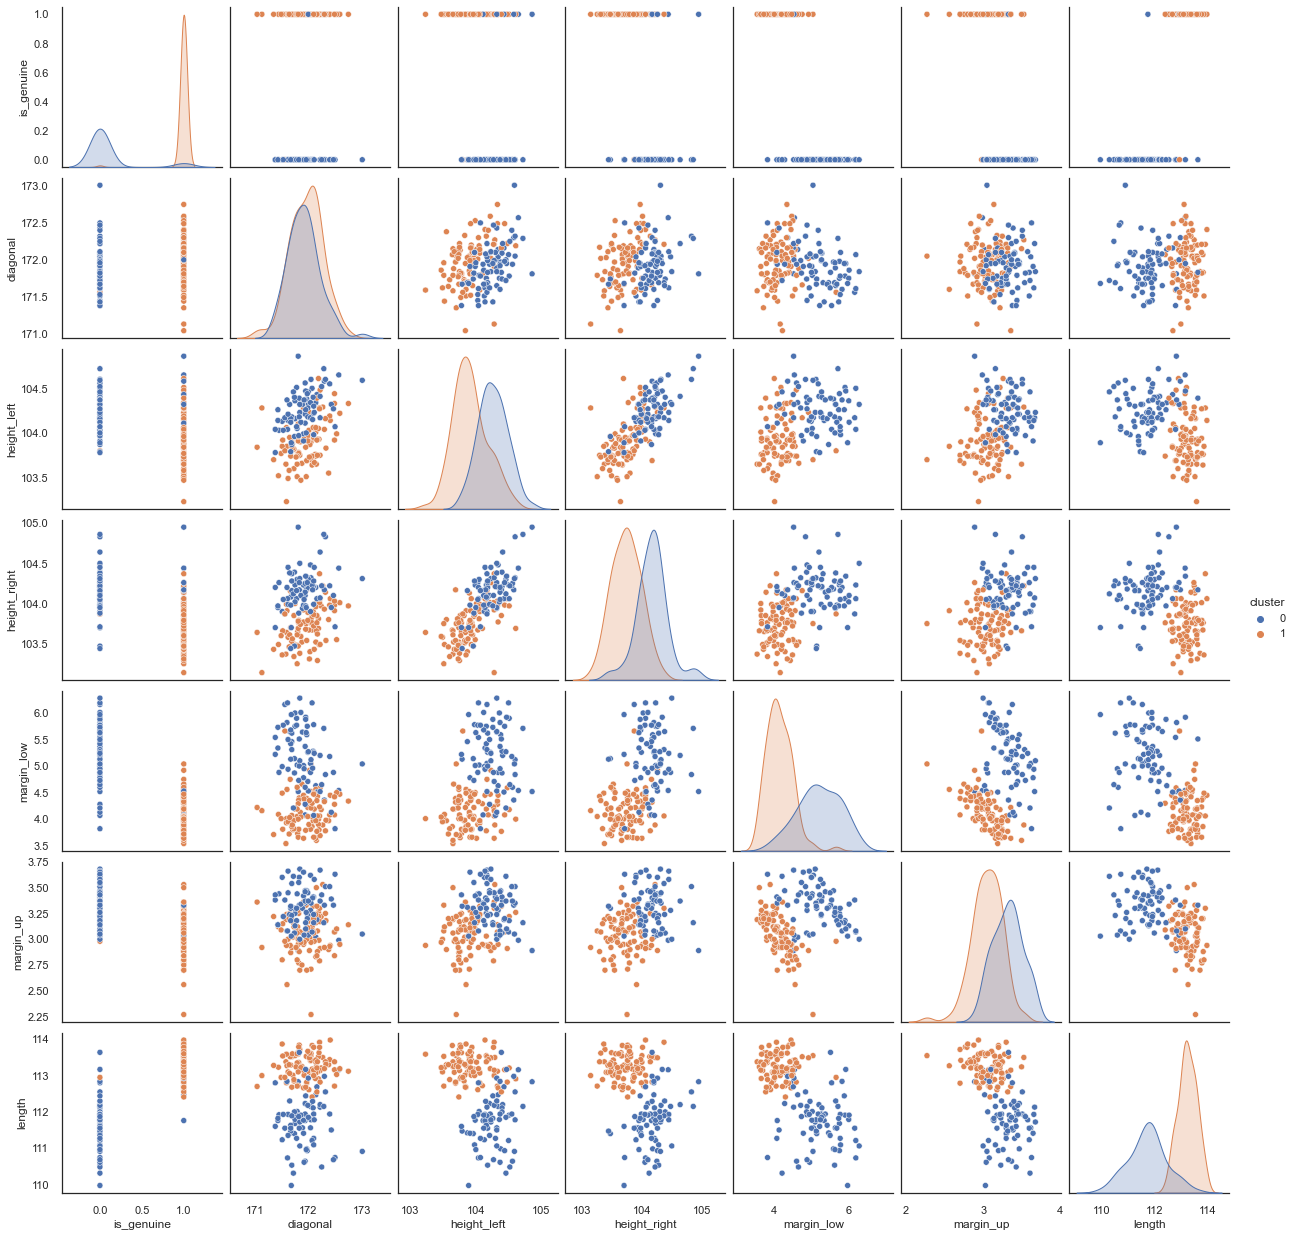

In [112]:
# visualisation des variables en fonction du groupe
sns.pairplot(df_notesK, hue='cluster')

#### lenght est une variable qui permet de bien distinguer l'autenticité des billets à l'inverse de diagonal

In [113]:
gpefaux = quel_groupe(df_notesK, kmBis.labels_)

le groupe des faux billets est le groupe 0


In [114]:
gpefaux

0

Par KMeans, 2 groupes apparaissent de taille 76 et 94. Or, notre dataset comprend 70 billets faux et 100 billets vrai. Le clustering n'est pas 100% fiable. Il existe des billets vrais dans le groupe faux et vice versa (4.7% d'erreur).

In [115]:
df_notesK.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.67       103.74        103.70        4.01       2.87   
2        True    171.83       103.76        103.76        4.40       2.88   
3        True    171.80       103.78        103.65        3.73       3.12   
4        True    172.05       103.70        103.75        5.04       2.27   

   length  cluster  
0  112.83        0  
1  113.29        1  
2  113.84        1  
3  113.63        1  
4  113.55        1

### Les groupes sont - ils distincts ?  <a class="anchor" id="groupes_distincts"></a>

#### Précédement on a vu que la variable height_left était gaussienne.
#### On effectue un test de variance sur cette variable et les 2 groupes

In [116]:
gpeFauxK = df_notesK[df_notesK['cluster']== gpefaux]['height_left']
gpeFauxK.shape

(76,)

In [117]:
gpeVraiK = df_notesK[df_notesK['cluster']!= gpefaux]['height_left']
gpeVraiK.shape

(94,)

#### Test d' égalité des variances (Levène) sur les groupes 0 et 1  <a class="anchor" id="test_levene"></a>

Hypothèses :
- HO : les variances sont égales
- H1 : les variances ne sont pas égales
- seuil alpha = 0.05

In [118]:
stat, p_value = levene(gpeFauxK, gpeVraiK)
p_value

0.30911069508212075

H0 ne peut pas être rejetée au seuil alpha choisi. Les variances des 2 groupes sont égales.

### Test de Student (d'égalité des moyennes) <a class="anchor" id="test_student"></a>

#### Redimensionnement des groupes

In [119]:
gpeVraiK_redim = gpeVraiK.sample(gpeFauxK.shape[0])
gpeVraiK_redim.shape

(76,)

Hypothèses :
- H0 : m4 = m5
- H1 : m4 != m5
- seuil alpha = 0.05

In [120]:
st.stats.ttest_ind(gpeVraiK_redim.dropna(),gpeFauxK.dropna(), equal_var=True)

Ttest_indResult(statistic=-8.718672732405013, pvalue=4.907201831625988e-15)

La pvalue est significativement plus faible que le seuil alpha. H0 peut être rejetée à ce seuil. Les moyennes des 2 groupes sont différentes. Les groupes formés par KMeans sont donc distincts

Visualisation 


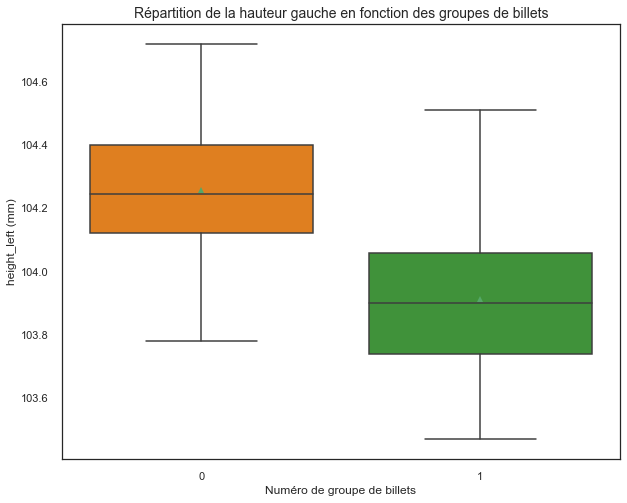

In [121]:
# Visualisation de la variable height_left en fonction des groupes
plt.figure(figsize=(10,8))
sns.boxplot(x='cluster', y='height_left', data=df_notesK, palette= 'Paired_r', showmeans=True, showfliers=False)
plt.title('Répartition de la hauteur gauche en fonction des groupes de billets', size=14)
plt.ylabel('height_left (mm)', size= 12)
plt.xlabel('Numéro de groupe de billets', size=12)
# plt.show()
plt.savefig("Répartition de la hauteur gauche en fonction des groupes de billets apres kmeans.jpg")

In [122]:
df_notesK['Id'] = df_notesK.index

In [123]:
# Id des billets vrais incorporés dans le groupe de faux billets
faux_faux = df_notesK.loc[(df_notesK['is_genuine'] == True) & (df_notesK['cluster'] ==  gpefaux), :]
faux_faux = faux_faux.Id.values
faux_faux

array([ 0,  5,  9, 65, 69, 84, 96], dtype=int64)

In [124]:
# Id des billets faux incorporés dans le groupe de vrais billets
faux_vrai = df_notesK.loc[(df_notesK['is_genuine'] == False) & (df_notesK['cluster'] !=  gpefaux), :]
# faux_vrai = faux_vrai.Id.values
faux_vrai

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
144       False    171.56        103.8        103.87        5.66       2.98   

     length  cluster   Id  
144  112.95        1  144

In [125]:
df_bad_gpe = df_notesK.loc[(df_notesK['is_genuine'] == True) & (df_notesK['cluster'] ==  gpefaux) |(df_notesK['is_genuine'] == False) & (df_notesK['cluster'] !=  gpefaux), :]
df_bad_gpe.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
5        True    172.57       104.65        104.44        4.54       2.99   

   length  cluster  Id  
0  112.83        0   0  
5  113.16        0   5

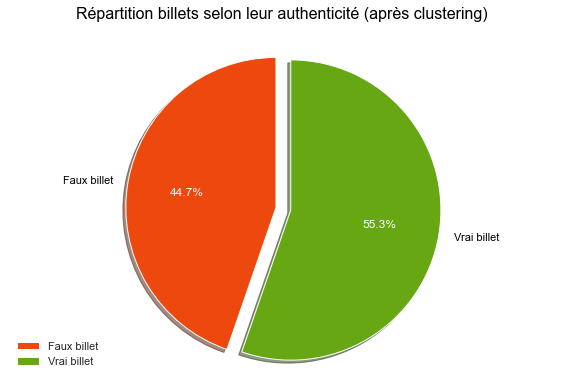

In [126]:
# Répartition des billets
labels = ['Faux billet', 'Vrai billet']
sizes = [76, 94]
# colors = sns.color_palette("", 2)
colors = ['#ed480e', '#66a713']
explode = (0, 0.1)
fig1, ax1 = plt.subplots()
patches, texts, autotexts = ax1.pie(sizes, explode=explode,  labels=labels, 
                                    autopct='%1.1f%%', shadow=True, startangle=90, colors=colors)
for text in texts:
    text.set_color('black')
for autotext in autotexts:
    autotext.set_color('white')
# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Répartition billets selon leur authenticité (après clustering)\n', color='black', fontsize=16)
ax1.axis('equal')  
plt.tight_layout()

plt.legend(loc ="lower left")
# plt.show()
plt.savefig('Répartition billets selon leur authenticité après clustering.jpg')

### ACP sur les groupes KMeans <a class="anchor" id="acpK"></a>

In [127]:
df_notesK.head(3)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.67       103.74        103.70        4.01       2.87   
2        True    171.83       103.76        103.76        4.40       2.88   

   length  cluster  Id  
0  112.83        0   0  
1  113.29        1   1  
2  113.84        1   2

In [128]:
# Récupération des colonnes pertinentes
df_notesK_acp = df_notesK[['diagonal', 'height_left',
       'height_right', 'margin_low',
       'margin_up', 'length']]

In [129]:
# préparation des données pour l'ACP 
df_notesK_acp = df_notesK_acp.fillna(df_notesK_acp.mean())
XK = df_notesK_acp.values
names = df_notesK['Id']
features = df_notesK_acp.columns

In [130]:
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [131]:
# Centrage et réduction des données
std_scale = StandardScaler().fit(XK)
X_scaled_K = std_scale.transform(XK)

In [132]:
# Vérification moyenne
np.mean(X_scaled_K, axis=0)

array([ 7.69580478e-15,  3.14728635e-14,  3.61958829e-14,  7.52339367e-16,
       -1.50467873e-15, -1.37510918e-14])

In [133]:
# Vérification ecart type
np.std(X_scaled_K, axis=0)

array([1., 1., 1., 1., 1., 1.])

In [134]:
# Nombre de composantes
n_comp = 6

In [135]:
# Calcul des composantes principales
cluster_pca = PCA(n_components=n_comp)
cluster_pca.fit(X_scaled_K)

PCA(n_components=6)

#### Eboulis des valeurs propres  <a class="anchor" id="eboulisK"></a>

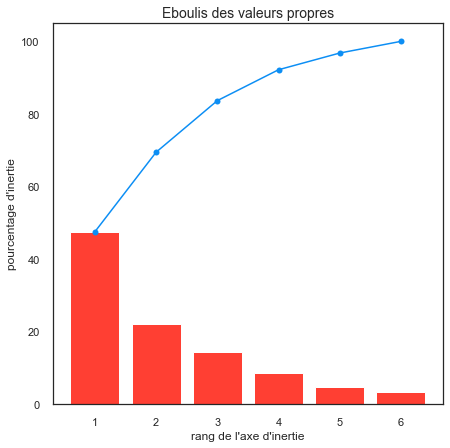

In [136]:
# Eboulis des valeurs propres
display_scree_plot(cluster_pca)
plt.savefig("eboulis acp clustersK.jpg")

#### Les 2 premières composantes expliquent presque  70% de la variance.

Ré entrainement du modèle avec le nombre de composantes trouvées précédement.

In [137]:
n_comp = 2

In [138]:
# Calcul des composantes principales
cluster_pca = PCA(n_components=n_comp)
X_reduced = cluster_pca.fit_transform(X_scaled_K)

In [139]:
# Vecteurs propres
cluster_pca.components_

array([[ 0.07327499,  0.47550205,  0.4918214 ,  0.43102671,  0.35253984,
        -0.46537288],
       [ 0.77963908,  0.33925019,  0.23554253, -0.32053699, -0.14111974,
         0.31453645]])

#### Cercle des corrélations (clustering KMeans) <a class="anchor" id="cercleK"></a>

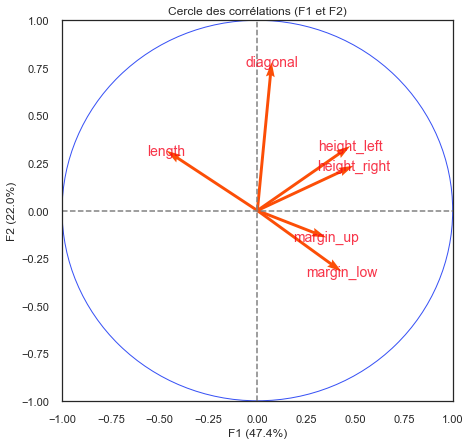

In [140]:
# Cercle des corrélations 
pcs = cluster_pca.components_
display_circles(pcs, n_comp, cluster_pca, [(0,1)], labels = np.array(features))
plt.savefig("cercle corr kmeans2.jpg")

In [141]:
# Calcul des composantes
df_composanteK = pd.DataFrame(X_reduced, index=df_notesK.cluster, columns=["F"+str(i+1) for i in range(2)])

In [142]:
df_composanteK.head(4)

F1        F2
cluster                    
0        2.153639  1.599709
1       -2.110416 -0.526039
1       -1.973152 -0.048102
1       -2.059795 -0.089105

In [143]:
df_bad_gpe.Id

0        0
5        5
9        9
65      65
69      69
84      84
96      96
144    144
Name: Id, dtype: int64

In [144]:
X_centroide = kmBis.cluster_centers_
X_centroide

array([[-0.07918471,  0.64514123,  0.71861116,  0.84016633,  0.63084075,
        -0.90264532],
       [ 0.06402168, -0.52160355, -0.58100477, -0.67928342, -0.51004145,
         0.72979834]])

#### Projection des individus (clustering KMeans) <a class="anchor" id="proj_ind_K"></a>

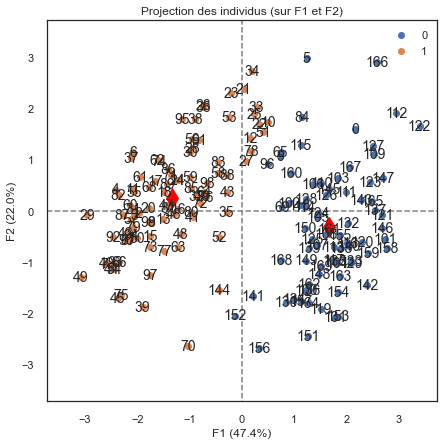

In [145]:
# Projection des individus
X_projected = cluster_pca.transform(X_scaled_K)
display_factorial_planes(X_projected, n_comp, cluster_pca, [(0,1)], illustrative_var=df_notesK.cluster, labels =names, centroid=X_centroide)
plt.savefig("proj individus_labels gpeK.jpg")
# Projection des nouveaux centroïdes
# X_projected_c = cluster_pca.transform(centroidK)
# display_factorial_planes(X_projected_c, n_comp, cluster_pca, [(0,1)], illustrative_var=df_notesK.cluster.unique())
# plt.savefig("proj centroids gpeK.jpg")

In [146]:
df_notesK.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.67       103.74        103.70        4.01       2.87   

   length  cluster  Id  
0  112.83        0   0  
1  113.29        1   1

In [147]:
# Vecteurs propres
cluster_pca.components_

array([[ 0.07327499,  0.47550205,  0.4918214 ,  0.43102671,  0.35253984,
        -0.46537288],
       [ 0.77963908,  0.33925019,  0.23554253, -0.32053699, -0.14111974,
         0.31453645]])

#### Projection des centroïdes sur les 2 composantes principales

Représentation des centroïdes

In [148]:
df_notesK.cluster.unique()

array([0, 1])

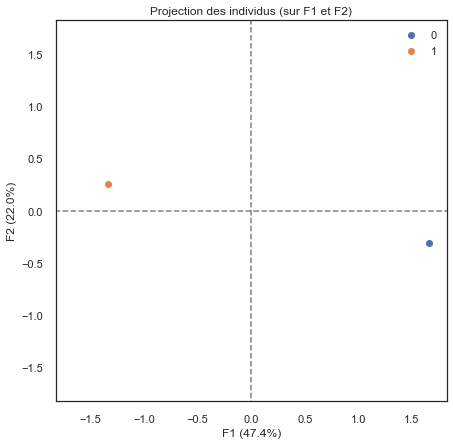

In [149]:
# Projection des nouveaux centroïdes
X_projected_c = cluster_pca.transform(X_centroide)
display_factorial_planes(X_projected_c, n_comp, cluster_pca, [(0,1)], illustrative_var=df_notesK.cluster.unique())

# plt.show()
plt.savefig("proj centroide gpeK.jpg")

In [150]:
for i in range(0,n_comp):
    print('f{} = {}'.format((i+1),cluster_pca.components_[i]))   

f1 = [ 0.07327499  0.47550205  0.4918214   0.43102671  0.35253984 -0.46537288]
f2 = [ 0.77963908  0.33925019  0.23554253 -0.32053699 -0.14111974  0.31453645]


### Mission 3 <a class="anchor" id="mission3"></a>

#### Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

target = 'is_genuine'

In [152]:
#  Modification de la variable is_geniune en 0 (billet faux), et 1 (billet vrai)
df_notes['is_genuine'] = df_notes['is_genuine'].map({True : 1,False : 0})

In [153]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

#### Avec sklearn : <a class="anchor" id="reg_log_sklearn"></a>

In [154]:
features

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

#### Caractéristiques des métriques en fonction de l'authenticité du billet

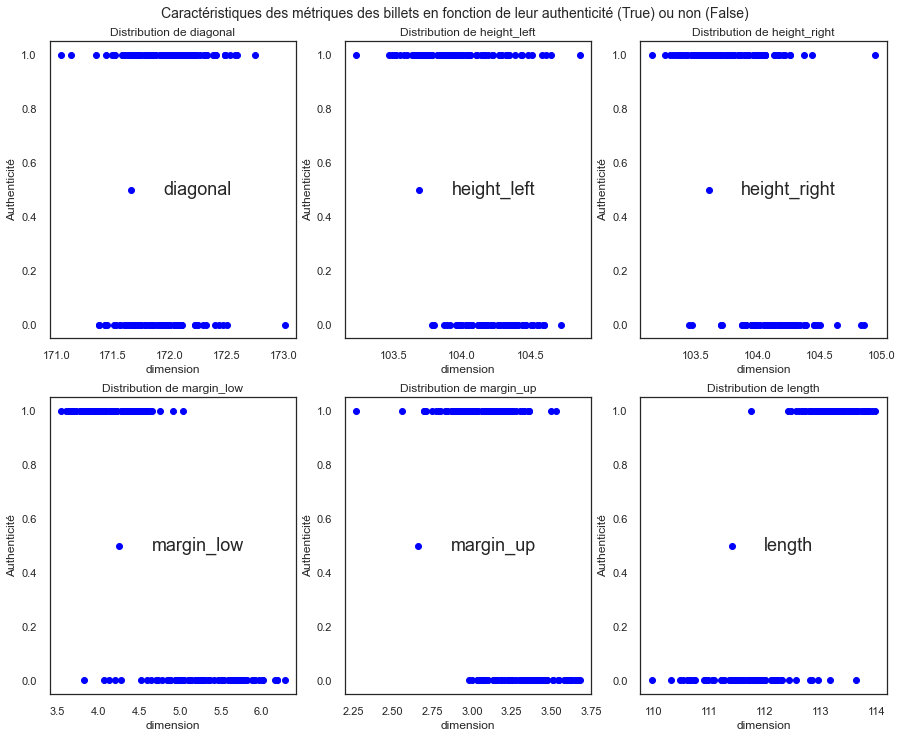

In [155]:
# Caractéristiques en fonction du type

a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter
fig = plt.figure(figsize=(15,12))

fig.suptitle('Caractéristiques des métriques des billets en fonction de leur authenticité (True) ou non (False)',  y=0.92, size = 14)
for variable in features :

    plt.subplot(a, b, c)
    pltX = df_notes.loc[:, 'is_genuine']
    pltY = df_notes.loc[:, variable]
    plt.scatter(pltY, pltX, color='blue', label=variable)
    plt.title(f'Distribution de {variable}')
    plt.xlabel('dimension')
    plt.ylabel('Authenticité')
    plt.legend(loc='center', fontsize = 18)
    
    c += 1
plt.savefig("Caractéristiques des métriques des billets en fonction de leur authenticité.jpg")
# plt.show()

#### Remarque : diagonal n'est pas significative ainsi que height_left et margin_up

In [156]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

In [157]:
df_notes_mod = df_notes[['is_genuine', 'height_right', 'margin_low', 'length']]
df_notes_mod.head()

is_genuine  height_right  margin_low  length
0           1        104.95        4.52  112.83
1           1        103.70        4.01  113.29
2           1        103.76        4.40  113.84
3           1        103.65        3.73  113.63
4           1        103.75        5.04  113.55

In [158]:
# Préparation données d'entrainement
X = df_notes_mod.iloc[:, 1:].values
y = df_notes_mod.iloc[:, 0].values

IMPORTANT : standardisation des données : **uniquement sur les données d'entrainement**. Les données test seront normalisées en utilisant la moyenne et l'écart type calculés sur les données d'entrainement. 

In [159]:
# Division du dataset en données d'entrainement et données de test (20% pour test, 80% pour l'entrainement)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(136, 3)
(34, 3)


In [160]:
# Données centrées et réduites
sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.fit_transform(x_test)

In [161]:
# Calcul de la moyenne et de l'écart type uniquement sur le dataset train (et pas celui de test)
sc.fit(x_train)

StandardScaler()

In [162]:
x_trainSc = sc.transform(x_train)

In [163]:
# Vérification moyenne
np.mean(x_trainSc, axis=0)

array([-3.75492121e-14,  1.38737061e-15,  9.53444839e-15])

In [164]:
# Vérification écart type
np.std(x_trainSc, axis=0)

array([1., 1., 1.])

In [165]:
# Normalisation du dataset test avec la moyenne et l'écart type calculé précédemment
x_testSc = sc.transform(x_test)

Création du modèle logistique

In [166]:
# Création du model
model_reg = LogisticRegression(random_state = 42)
model_reg.fit(x_trainSc, y_train)

LogisticRegression(random_state=42)

In [167]:
#  test du model donc prévision
predictions = model_reg.predict(x_testSc)
print(predictions)
print(y_test)
# predictions.score(x_test, y_test)

[0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0]
[0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [168]:
# help(LogisticRegression.predict)

In [169]:
#  Matrice de confusion
mc = confusion_matrix(y_test, predictions)
mc

array([[12,  0],
       [ 1, 21]], dtype=int64)

#### Matrice de confusion  <a class="anchor" id="m_conf_sk"></a>

In [170]:
# #  Matrice de confusion sur les valeurs standardisées
# plot_confusion_matrix(model_reg, x_testSc, y_test, cmap= plt.cm.Blues)
# plt.title("Matrice de confusion", size=14)
# plt.show()

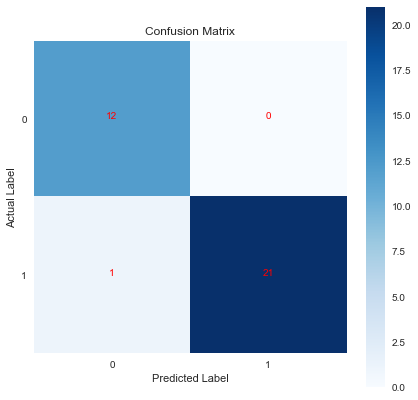

In [171]:
import itertools
with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(7,7), num=1)
    plt.imshow(mc, interpolation='nearest',cmap= plt.cm.Blues )
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    for i, j in itertools.product(range(mc.shape[0]), range(mc.shape[1])):
                plt.text(j, i,mc[i, j], horizontalalignment="center",color="red")
    plt.grid(None)
    plt.title('Confusion Matrix')
    plt.colorbar();
    plt.savefig("Confusion Matrix 3 var.jpg")

#### Le modèle est intéressant car il ne prédit AUCUN faux positif (billet faux considéré comme vrai). Il prédit un faux négatif (billet vrai considéré comme faux).

#### Evaluation du modèle <a class="anchor" id="eval_sk"></a>

#### Sensibilité : VP / (VP+FN)  taux de positifs classés positifs = Recall

In [172]:
VP = 21
FN = 1
print('sensibilité :{}'.format(VP /(VP+FN))) 

sensibilité :0.9545454545454546


#### Spécificité : VN / (VN + FP) taux de négatifs classés négatifs

In [173]:
VN = 12
FP = 0
print('spécificité :{}'.format(VN /(VN + FP))) 

spécificité :1.0


#### Précision : VP / (VP + FP)

In [174]:
print('précision :{}'.format(VP /(VP+ FP))) 

précision :1.0


#### F_score : 2 * VP /(2*VP+FP+FN)  moyenne harmonique de la sensibilité et de la précision

In [175]:
F_score = 2 * VP /(2*VP+FP+FN)
print('F_score :{}'.format(F_score)) 

F_score :0.9767441860465116


In [176]:
# Evaluation du model (données test)
from sklearn.metrics import classification_report, accuracy_score
print(classification_report(y_test, predictions))
print('accuracy_score : {}'.format(accuracy_score(y_test, predictions)))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.95      0.98        22

    accuracy                           0.97        34
   macro avg       0.96      0.98      0.97        34
weighted avg       0.97      0.97      0.97        34

accuracy_score : 0.9705882352941176


Le modèle est fidèle à 97 % (données test)

In [177]:
predictionsTrain = model_reg.predict(x_trainSc)
print(classification_report(y_train, predictionsTrain))
print('accuracy_score : {}'.format(accuracy_score(y_train, predictionsTrain)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        58
           1       0.97      0.99      0.98        78

    accuracy                           0.98       136
   macro avg       0.98      0.98      0.98       136
weighted avg       0.98      0.98      0.98       136

accuracy_score : 0.9779411764705882


Le modèle est fidèle à 97.8% (données train)

#### Autre méthode : utilisation de la fonction calculate_accuracy()

In [178]:
# Métrics avec "calculate_accuracy" fonction utilisant "accuracy_score"  
accuracy_train, accuracy_test, trained_model_reg = calculate_accuracy(model_reg, x_trainSc, x_testSc, y_train, y_test)

Train accuracy: 0.978 Test accuracy: 0.971


### Importance des différentes variables sur le modèle logistique <a class="anchor" id="inf_var"></a>

#### Calcul des coefficients bêta. Plus le coefficient bêta est grand (en valeur absolue), plus la variable a d'influence sur le modèle

In [179]:
# coef bêta
model_reg.coef_

array([[-0.50197345, -2.22491944,  2.52543387]])

height_right, Score: -0.50197
margin_low, Score: -2.22492
length, Score: 2.52543


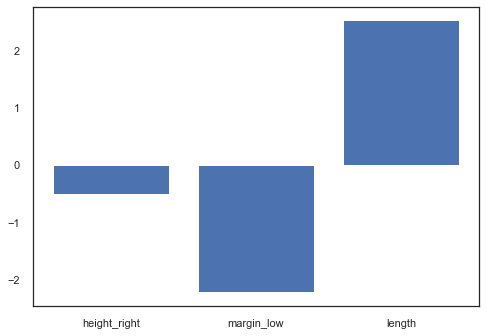

In [180]:
importance = model_reg.coef_[0]
for i,imp in enumerate(importance):
    print('%s, Score: %.5f' % (df_notes_mod.iloc[:, 1:].columns[i],imp))
plt.bar(df_notes_mod.iloc[:, 1:].columns, importance)
plt.show()

margin_low, length sont influentes (de manière "inverse") contrairement à height_right

Autre visualisation :

In [181]:
X = df_notes_mod.drop('is_genuine', axis=1)

C:\Users\isabe\anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:194: YellowbrickWarning:

detected multi-dimensional feature importances but stack=False, using mean to aggregate them.



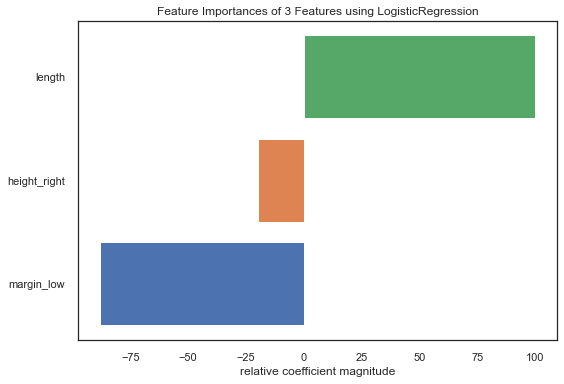

<Figure size 576x396 with 0 Axes>

In [182]:
viz = FeatureImportances(model_reg)
viz.fit(X, y)
viz.show()
plt.savefig("reg log importances des variables (3).jpg")

### Etude des corrélations des variables choisies 

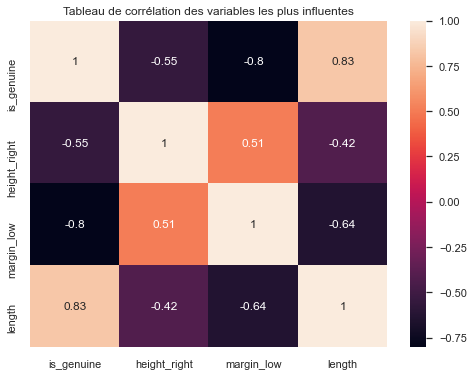

In [183]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_notes_mod.corr(method='pearson'), annot=True)
plt.title('Tableau de corrélation des variables les plus influentes')
# plt.show()
plt.savefig("Tableau de corrélation var 3 .jpg")

#### Courbe ROC <a class="anchor" id="roc_sk"></a>

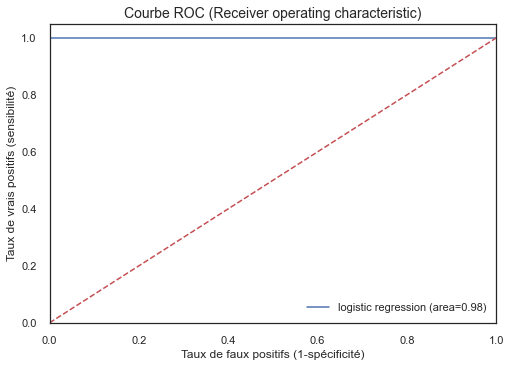

In [184]:
# Courbe de ROC
logit_roc_auc = roc_auc_score(y_test, predictions)
y_pred_proba = model_reg.predict_proba(x_testSc)[::,1]                            
fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='logistic regression (area=%0.2f)' %logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs (1-spécificité)', size=12)
plt.ylabel('Taux de vrais positifs (sensibilité)', size=12)
plt.title('Courbe ROC (Receiver operating characteristic)', size=14)
plt.legend(loc='lower right')
plt.savefig("courbe roc variables (3)title.jpg")
plt.show()

- AUC = 0.5 : dans le pire des cas 
- AUC = 1 : dans le meilleur des cas

#### Avec un RandomForest

In [185]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42).fit(x_trainSc, y_train)
y_pred_rf = rf.predict(x_testSc)
display(pd.crosstab(y_test, y_pred_rf))
print('Via random forest, accuracy :', accuracy_score(y_test, y_pred_rf))

col_0   0   1
row_0        
0      12   0
1       1  21

Via random forest, accuracy : 0.9705882352941176


Modèle fidèle à 97 % sur les données test

### Avec fichier de données "example" <a class="anchor" id="example"></a>

In [186]:
data_example = pd.read_csv('example.csv', encoding = ENCODAGE).copy()
data_example.head(7)

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

In [187]:
# Récupération des variables significatives pour notre modèle
data_example_rlog = data_example[['height_right','margin_low','length']]

In [188]:
# Données centrées et réduites
sc = StandardScaler()
X_scaled = sc.fit_transform(data_example_rlog)
X_scaled

array([[-1.22890038,  0.43822393, -1.12401394],
       [ 0.44945894,  1.4937023 , -0.28910336],
       [ 0.90460723,  0.14429325, -0.93709366],
       [ 1.04684107, -0.59053347,  1.09410669],
       [-1.17200685, -1.48568601,  1.25610427]])

In [189]:
# Prédictions
predictions = model_reg.predict(X_scaled)
predictions

array([0, 0, 0, 1, 1], dtype=int64)

In [190]:
y_pred_proba = model_reg.predict_proba(X_scaled)[::,1]
y_pred_proba

array([0.0641409 , 0.0226936 , 0.06752654, 0.98317423, 0.99949094])

In [191]:
# Présentation des données dans un dataframe
df_predictions = pd.DataFrame({'id': data_example.id.values,
                         'predictions' : predictions, 'probabilité' : y_pred_proba })
df_predictions

id  predictions  probabilité
0  A_1            0     0.064141
1  A_2            0     0.022694
2  A_3            0     0.067527
3  A_4            1     0.983174
4  A_5            1     0.999491

In [192]:
df_predictions['predictions']

0    0
1    0
2    0
3    1
4    1
Name: predictions, dtype: int64

In [193]:
df_predictions['is_genuine'] = ["True" if x >= 0.5 else "False" for x in df_predictions['probabilité']] 
df_predictions

id  predictions  probabilité is_genuine
0  A_1            0     0.064141      False
1  A_2            0     0.022694      False
2  A_3            0     0.067527      False
3  A_4            1     0.983174       True
4  A_5            1     0.999491       True

#### Programme de détection de billets <a class="anchor" id="prog_sk"></a>

In [194]:
predict_billet(data_example)

id  predictions  probabilité is_genuine
0  A_1            0     0.064141      False
1  A_2            0     0.022694      False
2  A_3            0     0.067527      False
3  A_4            1     0.983174       True
4  A_5            1     0.999491       True

### Juste pour voir ....  <a class="anchor" id="juste_voir"></a>

#### Avec Statsmodels <a class="anchor" id="statsmodels"></a>

In [195]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

#### Avec les variables 'is_genuine', 'height_right', 'margin_low', 'length'

Echantillonnage des données train et test en 'manuel'

In [196]:
df_notes_stat = df_notes[['is_genuine','height_right','margin_low','length']] .copy()

#### Echantillonnage "manuel"  <a class="anchor" id="ech_manuel"></a>

In [197]:
# Echantillonnage "manuel" 80% données entraînement et 20% données test
X_trainManu = df_notes_stat.sample(frac=0.8, random_state= 0)
X_testManu = df_notes_stat.drop(X_trainManu.index)
y_test = X_testManu.is_genuine
X_trainManu = X_trainManu.drop('is_genuine', axis=1)
X_testManu = X_testManu.drop('is_genuine', axis=1)
print(X_trainManu.shape)
print(X_testManu.shape)

(136, 3)
(34, 3)


Echantillonnage des données train et test par sklearn

In [198]:
# définit les variables dépendantes et indépendantes
X = df_notes_stat[['height_right','margin_low','length']]
y = df_notes_stat['is_genuine']

In [199]:
# Division du dataset en données d'entrainement et données de test (20% pour test, 80% pour l'entrainement)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(136, 3)
(34, 3)


In [200]:
reg_log4 = smf.glm('is_genuine ~ length + margin_low + height_right',
                   data=df_notes_stat, family=sm.families.Binomial()).fit()
print(reg_log4.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      166
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.2907
Date:                Mon, 26 Jul 2021   Deviance:                       8.5814
Time:                        12:53:41   Pearson chi2:                     10.2
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -986.0635    710.322     -1.388   

In [201]:
# Prédictions sur les données test
predictions_four = reg_log4.predict(X_testManu)
# predictions_four = reg_log4.predict(x_test)
prediction = list(map(round, predictions_four))

In [202]:
# Comparaison des valeurs du dataset et celles prédites
print('Actual values', list(y_test))
print('Predictions :', prediction)

Actual values [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
Predictions : [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [203]:
# confusion matrix
cm = confusion_matrix(y_test, prediction) 
print ("Confusion Matrix : \n", cm) 
  
# accuracy score du modèle
print('Test accuracy = ', accuracy_score(y_test, prediction))

Confusion Matrix : 
 [[ 3  9]
 [11 11]]
Test accuracy =  0.4117647058823529


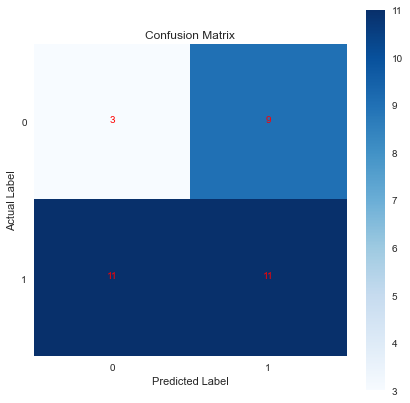

In [204]:
# Visualisation de la matrice de confusion
import itertools
with plt.style.context(('ggplot', 'seaborn')):
    fig = plt.figure(figsize=(7,7), num=1)
    plt.imshow(cm, interpolation='nearest',cmap= plt.cm.Blues )
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
                plt.text(j, i,cm[i, j], horizontalalignment="center",color="red")
    plt.grid(None)
    plt.title('Confusion Matrix')
    plt.colorbar();
    plt.savefig("Confusion Matrix 3 var statmodels.jpg")

Le modèle calculé avec statmodels donne une fidélité de 97 % sur les données de test. Même fidélité qu'avec sklearn.

#### Avec juste la variable "length"

In [205]:
#  régression logistique avec une seule variable -données non centrées et réduites
reg_log1 = smf.glm('is_genuine ~ length', data=df_notes, family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      168
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31.836
Date:                Mon, 26 Jul 2021   Deviance:                       63.672
Time:                        12:53:42   Pearson chi2:                     371.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -549.0766     87.271     -6.292      0.0

In [206]:
beta1 = reg_log1.params[0]
beta2 = reg_log1.params[1]

In [207]:
x = np.linspace(start=109, stop=114, num=50)
y = np.exp(beta1+beta2*x)/(1+np.exp(beta1+beta2*x))
reg_log = pd.DataFrame(data={'length': x, 'is_genuine': y})

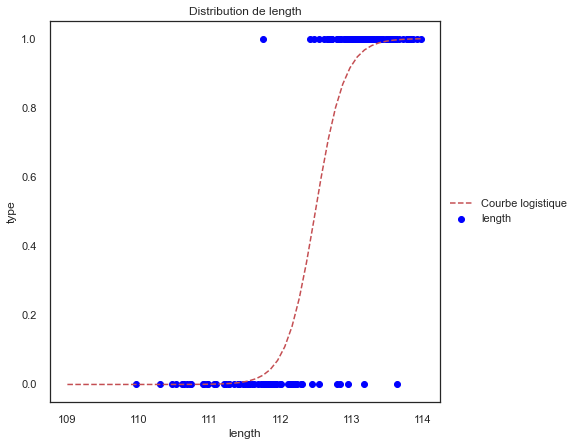

In [208]:
plt.figure(figsize=(7,7))

pltX = df_notes.loc[:, 'is_genuine']
pltY = df_notes['length']
plt.scatter(pltY, pltX, color='blue', label=variable)
plt.title(f'Distribution de {variable}')
plt.xlabel('length')
plt.ylabel('type')
plt.legend()

plt.plot(reg_log['length'], reg_log['is_genuine'],  "r--", label='Courbe logistique')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [209]:
# %matplotlib notebook
# librairies pour la régression linéaire animée
from matplotlib.animation import FuncAnimation
from sklearn.linear_model import LinearRegression

Avec les variables **length + margin_up + height_left + height_right'** 

In [210]:
reg_log2 = smf.glm('is_genuine ~ length + margin_up + height_left + height_right',
                   data=df_notes, family=sm.families.Binomial()).fit()
print(reg_log2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      165
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -23.891
Date:                Mon, 26 Jul 2021   Deviance:                       47.782
Time:                        12:53:43   Pearson chi2:                     132.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -8.3284    174.202     -0.048   

In [211]:
beta1 = reg_log2.params[0]
beta2 = reg_log2.params[1]
beta3 = reg_log2.params[2]
beta4 = reg_log2.params[3]
beta5 = reg_log2.params[4]

In [212]:
beta5

-4.201377989740179

In [213]:
reg_log3 = smf.glm('is_genuine ~ length + margin_low + height_right',
                   data=df_notes, family=sm.families.Binomial()).fit()
print(reg_log3.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             is_genuine   No. Observations:                  170
Model:                            GLM   Df Residuals:                      166
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.2907
Date:                Mon, 26 Jul 2021   Deviance:                       8.5814
Time:                        12:53:43   Pearson chi2:                     10.2
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     -986.0635    710.322     -1.388   

Il apparaît que height_right n'est pas influente (p_value > 0.05). 

#### Autre régression logistique sans centrage et réduction des données et sur variables "height_right", "margin_low", "length"

Mêmes variables que le modèle choisi pour le projet <a class="anchor" id="scaled"></a>

In [214]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

In [215]:
df_model = df_notes.drop(columns=['diagonal','margin_up', 'height_left'])
v_quanti = df_model.columns
for var in v_quanti:
    df_model[var] = preprocessing.LabelEncoder().fit_transform(df_model[var])

X = df_model.drop(columns=['is_genuine'])
y = df_model['is_genuine']
# Séparation du dataset en données entrainement et données test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [216]:
X_test.shape

(68, 3)

In [217]:
y_test.shape

(68,)

In [218]:
lg_reg = LogisticRegression()
lg_reg.fit(X_train, y_train)

LogisticRegression()

height_right, Score: -0.01692
margin_low, Score: -0.28705
length, Score: 0.23451


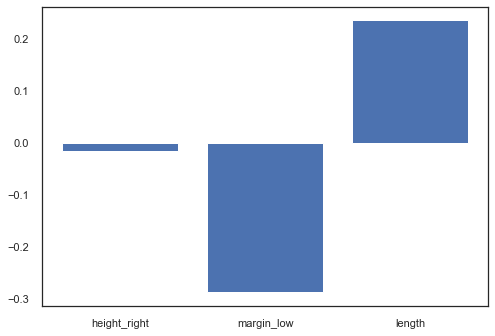

In [219]:
importance = lg_reg.coef_[0]
for i,imp in enumerate(importance):
    print('%s, Score: %.5f' % (X.columns[i],imp))
plt.bar(X.columns, importance)
plt.show()

In [220]:
y_pred = lg_reg.predict(X_test)

In [221]:
# Matrice de confusion
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[25,  0],
       [ 4, 39]], dtype=int64)

- Tout positif : 25 (bonne prédiction sur positif )
- tout négatif : 39 (bonne prédiction sur négatif)
- faux positif : 0 
- faux négatif : 4

In [222]:
log_reg = LogisticRegression(random_state=42, max_iter=200, class_weight='balanced').fit(X_train, y_train)
y_pred_reg = log_reg.predict(X_test)

display(pd.crosstab(y_test, y_pred_reg))
print('Via régression logistique, accuracy :', accuracy_score(y_test, y_pred_reg))

col_0        0   1
is_genuine        
0           25   0
1            4  39

Via régression logistique, accuracy : 0.9411764705882353


In [223]:
y_pred_regTrain = model_reg.predict(X_train)
print(classification_report(y_train, y_pred_regTrain))
print('accuracy_score : {}'.format(accuracy_score(y_train, y_pred_regTrain)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.97      0.98      0.97        57

    accuracy                           0.97       102
   macro avg       0.97      0.97      0.97       102
weighted avg       0.97      0.97      0.97       102

accuracy_score : 0.9705882352941176


Le modèle est fidèle à 97% sur les données train

In [224]:
print(classification_report(y_test, y_pred_reg))
print('accuracy_score : {}'.format(accuracy_score(y_test, y_pred_reg)))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93        25
           1       1.00      0.91      0.95        43

    accuracy                           0.94        68
   macro avg       0.93      0.95      0.94        68
weighted avg       0.95      0.94      0.94        68

accuracy_score : 0.9411764705882353


Le modèle est moins bon. Il est fidèle à 94 % pour les données test

#### RandomForest <a class="anchor" id="rf"></a>

In [225]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
display(pd.crosstab(y_test, y_pred_rf))
print('Via random forest, accuracy :', accuracy_score(y_test, y_pred_rf))

col_0        0   1
is_genuine        
0           25   0
1            4  39

Via random forest, accuracy : 0.9411764705882353


height_right, Score: 0.19314
margin_low, Score: 0.38734
length, Score: 0.41952


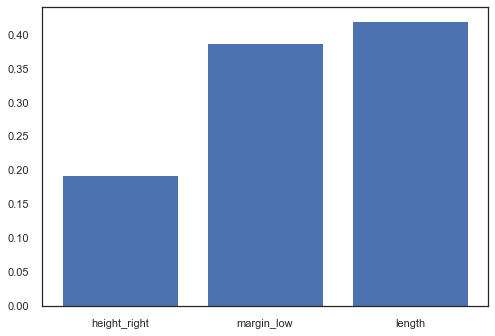

In [226]:
# random forest
importance = rf.feature_importances_

for i,imp in enumerate(importance):
    print('%s, Score: %.5f' % (X.columns[i],imp))

plt.bar(X.columns, importance)
plt.show()

#### Courbe de ROC <a class="anchor" id="roc"></a>

In [227]:
log_reg.predict(X_test)

array([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1], dtype=int64)

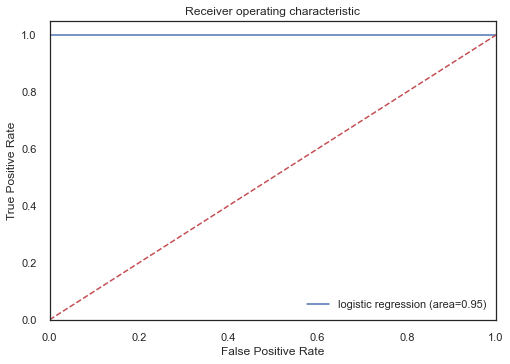

In [228]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, y_pred_reg)
                             
fpr, tpr, thresholds = roc_curve(y_test,log_reg.predict_proba(X_test)[::,1])
plt.figure()
plt.plot(fpr, tpr, label='logistic regression (area=%0.2f)' %logit_roc_auc)
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')
# plt.savefig("courbe roc variables (3).jpg")
plt.show()

### Reprise du dataset avec les données centrées réduites puis construction du modèle logistique avec dans un premier temps TOUTES les variables (overfitting ????)

On prend toutes les variables <a class="anchor" id="a_nouveau"></a>

In [229]:
df_notes.head(2)

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           1    171.81       104.86        104.95        4.52       2.89   
1           1    171.67       103.74        103.70        4.01       2.87   

   length  
0  112.83  
1  113.29

In [230]:
# Préparation données d'entrainement
X_T = df_notes.iloc[:, 1:].values
y_T = df_notes.iloc[:, 0].values

In [231]:
df_notes.iloc[:, 1:].columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [232]:
x_train, x_test, y_train, y_test = train_test_split(X_T, y_T, test_size=0.2, random_state=42)
print(x_train.shape)
print(x_test.shape)

(136, 6)
(34, 6)


In [233]:
# Données centrées et réduites
sc = StandardScaler()

In [234]:
sc.fit(x_train)

StandardScaler()

In [235]:
x_trainScT = sc.transform(x_train)

In [236]:
# Vérification moyenne
np.mean(x_trainScT, axis=0)

array([-1.24227120e-14,  9.39452764e-14, -3.75492121e-14,  1.38737061e-15,
       -4.28252205e-15,  9.53444839e-15])

In [237]:
# Vérification réduction
np.std(x_trainScT, axis=0)

array([1., 1., 1., 1., 1., 1.])

In [238]:
x_testScT = sc.transform(x_test)

In [239]:
# Création du modèle
model_regT = LogisticRegression(random_state = 42)

In [240]:
#  Entrainement du modèle
model_regT.fit(x_trainScT, y_train)

LogisticRegression(random_state=42)

In [241]:
# Test du modèle avec prévision
prédictionsT = model_regT.predict(x_testScT)
print(prédictionsT)
# print(y_test)

[0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0]


In [242]:
# Métrics avec "calculate_accuracy" fonction utilisant "accuracy_score"  
accuracy_train, accuracy_test, model_regT = calculate_accuracy(model_regT, x_trainScT, x_testScT, y_train, y_test)

Train accuracy: 0.993 Test accuracy: 1.000


Le modèle est parfait peut-être un peu trop ....

#### Visualisation par la matrice de confusion

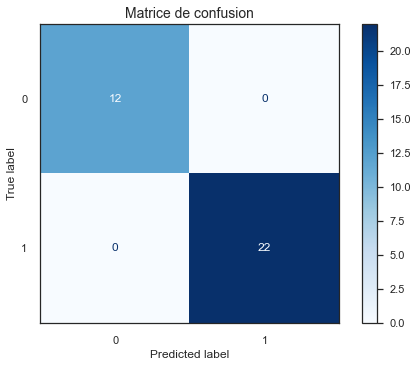

In [243]:
#  Matrice de confusion sur les valeurs standardisées
plot_confusion_matrix(model_regT, x_testScT, y_test, cmap= plt.cm.Blues)
plt.title("Matrice de confusion", size=14)
plt.show()

Prédiction parfaite Overfitting ????

### Influences des variables dans la régression logistique

In [244]:
df_notes.iloc[:, 1:].columns

Index(['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up',
       'length'],
      dtype='object')

In [245]:
model_regT.coef_

array([[ 0.1371122 , -0.23151283, -0.43605127, -2.1303779 , -1.46442188,
         1.78825634]])

In [246]:
# coef bêta
coefficients = pd.DataFrame(model_regT.coef_[0], index = df_notes.iloc[:, 1:].columns, columns=['beta'])
coefficients.head(20)

beta
diagonal      0.137112
height_left  -0.231513
height_right -0.436051
margin_low   -2.130378
margin_up    -1.464422
length        1.788256

Visualisation

In [247]:
coefficients = coefficients.sort_values(by='beta', ascending=False)
coefficients = coefficients.rename_axis('variable').reset_index()
coefficients

variable      beta
0        length  1.788256
1      diagonal  0.137112
2   height_left -0.231513
3  height_right -0.436051
4     margin_up -1.464422
5    margin_low -2.130378

Text(0.5, 1.0, 'Influence des variables sur le modèle')

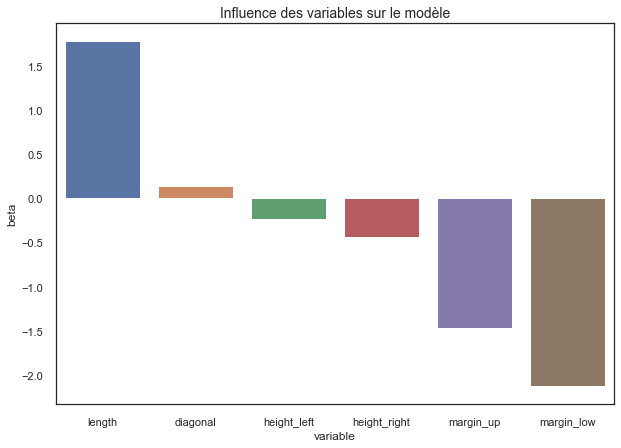

In [248]:
plt.figure(figsize=(10,7))
sns.barplot(x='variable', y='beta', data=coefficients)
plt.title('Influence des variables sur le modèle', size=14)
# plt.show()

Les variables les plus influentes sur le modèle sont : **length, margin_up et margin_low**

### Analyse de la corrélation entre les variables les plus influentes

In [249]:
n_features = 4
coefficients['abs_beta'] = coefficients['beta'].abs() # calcul des valeurs absolues des beta
coefficients = coefficients.sort_values(by='abs_beta', ascending=False) # tri par valeurs absolues
top_features = coefficients.head(n_features).variable.values # liste de n meilleurs features
print('Top features LR:', top_features)

Top features LR: ['margin_low' 'length' 'margin_up' 'height_right']


In [250]:
top_features

array(['margin_low', 'length', 'margin_up', 'height_right'], dtype=object)

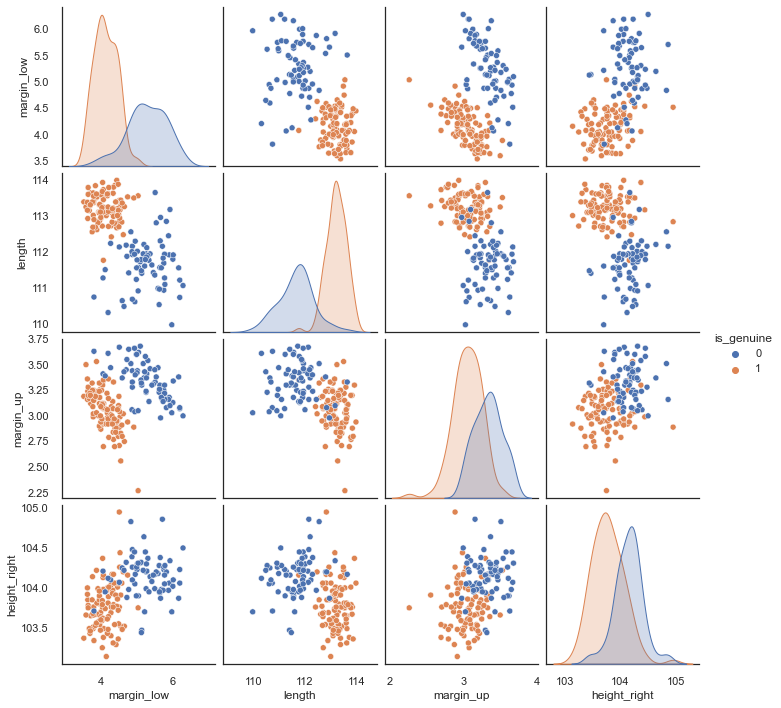

In [251]:
sns.pairplot(df_notes[[*top_features, 'is_genuine']], hue='is_genuine')

Visualisation des corrélations des top_variables

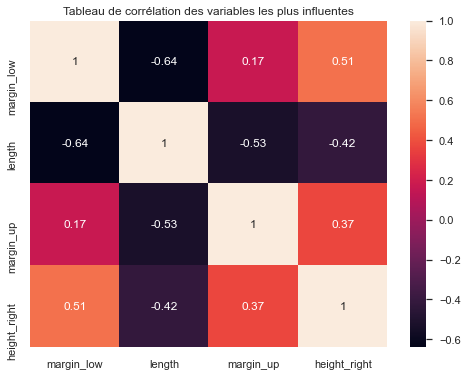

In [252]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_notes[top_features].corr(method='pearson'), annot=True)
plt.title('Tableau de corrélation des variables les plus influentes')
plt.show()
# plt.savefig("Tableau de corrélation .jpg")

Récupération des variables faiblement corrélées entre elles (R²<0.50) soit margin_low, margin_up et height_right (ainsi les 3 métriques sont représentées)

#### Combien de variables doit-on introduire dans le modèle ?

In [253]:
for i in range(len(top_features)):
    selected_features = top_features[0:i+1]
    print(selected_features)
    accuracy_train, accuracy_test, trained_model_reg = calculate_accuracy(model_reg, x_trainScT[:,i].reshape(x_trainScT.shape[0],1), x_testScT[:,i].reshape(x_testScT.shape[0],1), y_train, y_test)

['margin_low']
Train accuracy: 0.574 Test accuracy: 0.647
['margin_low' 'length']
Train accuracy: 0.662 Test accuracy: 0.735
['margin_low' 'length' 'margin_up']
Train accuracy: 0.779 Test accuracy: 0.765
['margin_low' 'length' 'margin_up' 'height_right']
Train accuracy: 0.919 Test accuracy: 0.971


#### Le modèle avec les 3 variables 'height_right', 'margin_low', 'length' constitue un meilleur modèle que celui proposé avec le calcul des métrics béta top_features.

#### Pour avoir un modème aussi performant, il faudrait utiliser 4 variables 'margin_low', 'length', 'margin_up', 'height_right'